## Analysis and Plots

#### Libraries

In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.path as mpath
import matplotlib.patches as patches
import matplotlib.cm as cm
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
import cartopy.mpl.gridliner as gridliner
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings("ignore", message="All-NaN slice encountered")
%matplotlib inline
import time
import cftime
import seaborn as sns
import calendar
import datetime
from pyproj import Proj, transform
from scipy.interpolate import interp1d
from sklearn.linear_model import LinearRegression

In [2]:
path = '/storage2/tkyeimiah'

In [3]:
start_time=time.time()

path = '/storage2/tkyeimiah'


aice_dh = xr.open_dataset(path+'/iHESP/EM1/hist/aice_hist/aice_hist.nc')
aice_dp = xr.open_dataset(path+'/iHESP/EM1/proj/aice_proj/aice_proj.nc')


hi_dh = xr.open_dataset(path+'/iHESP/EM1/hist/hi_hist/hi_hist.nc')
hi_dp = xr.open_dataset(path+'/iHESP/EM1/proj/hi_proj/hi_proj.nc')


end_time=time.time()
elapsed_time = end_time - start_time
hours, remainder = divmod(elapsed_time, 3600)
minutes, seconds = divmod(remainder, 60)

print("Execution time: ", hours, "hours,", minutes, "minutes,", seconds, "seconds")

Execution time:  0.0 hours, 0.0 minutes, 0.6812732219696045 seconds


In [4]:
def shift_month(ds):
    ds = ds.copy()  
    # Convert each cftime.DatetimeNoLeap to pandas datetime
    time_as_pd_datetime = [pd.Timestamp(date.year, date.month, date.day) for date in ds['time'].values]

    # Subtract one month
    time_as_pd_datetime = [date - pd.DateOffset(months=1) for date in time_as_pd_datetime]

    # Convert back to cftime.DatetimeNoLeap
    time_as_cftime = [cftime.DatetimeNoLeap(date.year, date.month, date.day) for date in time_as_pd_datetime]

    # Replace the time coordinate in the dataset
    ds['time'] = time_as_cftime
    
    return ds

### CESM-HR

In [5]:
aice_hist=shift_month(aice_dh['aice'])
aice_proj=shift_month(aice_dp['aice'])

tarea_hist=aice_dh['uarea']
tarea_proj=aice_dp['uarea']

In [6]:
# Define the Labrador coast boundaries (replace these with your desired region)
lon_min, lon_max =287, 315 #73W & 45W
lat_min, lat_max =51,69


# Create a mask for Labrador coast 
mask_hist = ((aice_hist.TLAT >= lat_min) & (aice_hist.TLAT <= lat_max) &
        (aice_hist.TLON >= lon_min) & (aice_hist.TLON <= lon_max))

mask_hist2 = ((tarea_hist.TLAT >= lat_min) & (tarea_hist.TLAT <= lat_max) &
        (tarea_hist.TLON >= lon_min) & (tarea_hist.TLON <= lon_max))

mask_proj = ((aice_proj.TLAT >= lat_min) & (aice_proj.TLAT <= lat_max) &
        (aice_proj.TLON >= lon_min) & (aice_proj.TLON <= lon_max))

mask_proj2 = ((tarea_proj.TLAT >= lat_min) & (tarea_proj.TLAT <= lat_max) &
        (tarea_proj.TLON >= lon_min) & (tarea_proj.TLON <= lon_max))

# Apply the mask to the aice variable
aice_hist_region_ =aice_hist.where(mask_hist, drop=True)
tarea_hist_region_=tarea_hist.where(mask_hist2, drop=True)
aice_proj_region_ =aice_proj.where(mask_proj, drop=True)
tarea_proj_region_=tarea_proj.where(mask_proj2, drop=True)

#### SIE

In [7]:
sic_greater_15hist = xr.where(aice_hist_region_ >= 15, 1, 0)
sic_greater_15proj = xr.where(aice_proj_region_ >= 15, 1, 0)

aice_hist_region = (sic_greater_15hist * tarea_hist_region_)/1e12
aice_proj_region = (sic_greater_15proj * tarea_proj_region_)/1e12

In [8]:
#plot for article
model_1991_00 = aice_hist_region.sel(time=slice('1991-01-01','2000-12-31'))
model_2001_05 = aice_hist_region.sel(time=slice('2001-01-01','2005-12-31'))
model_2006_20 = aice_proj_region.sel(time=slice('2006-01-01','2020-12-31'))
model_2001_20 = xr.concat([model_2001_05, model_2006_20], dim='time')
model_2041_60 = aice_proj_region.sel(time=slice('2041-01-01','2060-12-31'))
model_2081_100= aice_proj_region.sel(time=slice('2081-01-01','2100-12-31'))

In [9]:
model_1991_00_monthly = model_1991_00.groupby('time.month').mean('time').sum(('nj','ni'))
model_2001_20_monthly = model_2001_20.groupby('time.month').mean('time').sum(('nj','ni'))

model_1991_00_monmax = model_1991_00.groupby('time.month').max('time').sum(('nj','ni'))
model_2001_20_monmax = model_2001_20.groupby('time.month').max('time').sum(('nj','ni'))

model_1991_00_monmin = model_1991_00.groupby('time.month').min('time').sum(('nj','ni'))
model_2001_20_monmin = model_2001_20.groupby('time.month').min('time').sum(('nj','ni'))

#### SIC

In [10]:
#plot for article
model_sic_1991_00 = aice_hist_region_.sel(time=slice('1991-01-01','2000-12-31'))
model_sic_2001_05 = aice_hist_region_.sel(time=slice('2001-01-01','2005-12-31'))
model_sic_2006_20 = aice_proj_region_.sel(time=slice('2006-01-01','2020-12-31'))
model_sic_2001_20 = xr.concat([model_sic_2001_05, model_sic_2006_20], dim='time')
model_sic_2041_60 = aice_proj_region_.sel(time=slice('2041-01-01','2060-12-31'))
model_sic_2081_100= aice_proj_region_.sel(time=slice('2081-01-01','2100-12-31'))

In [11]:
model_hist=aice_hist_region_.sel(time=slice('1990-01-01','2005-12-31'))
model_proj=aice_proj_region_.sel(time=slice('2006-01-01','2020-12-31'))
model_CT_sel= xr.concat([model_hist, model_proj], dim='time')

#### SIT

In [12]:
hi_hist=shift_month(hi_dh['hi'])
hi_proj=shift_month(hi_dp['hi'])

In [13]:
# Define the Labrador coast boundaries (replace these with your desired region)
lon_min, lon_max =287, 315 #73W & 45W
lat_min, lat_max =51,69

# Create a mask for Labrador coast 
mask_hist3 = ((hi_hist.TLAT >= lat_min) & (hi_hist.TLAT <= lat_max) &
              (hi_hist.TLON >= lon_min) & (hi_hist.TLON <= lon_max))


mask_proj3 = ((hi_proj.TLAT >= lat_min) & (hi_proj.TLAT <= lat_max) &
              (hi_proj.TLON >= lon_min) & (hi_proj.TLON <= lon_max))

# Apply the mask to the aice variable
hi_hist_region=hi_hist.where(mask_hist3, drop=True)
hi_proj_region=hi_proj.where(mask_proj3, drop=True)

hi_hist_region1=hi_hist_region.where(aice_hist_region_ >= 15, np.nan)
hi_proj_region1=hi_proj_region.where(aice_proj_region_ >= 15, np.nan)

In [14]:
hi_hist_region1=hi_hist_region
hi_proj_region1=hi_proj_region

In [15]:
#plot for article
model_hi_1991_00 = hi_hist_region.sel(time=slice('1991-01-01','2000-12-31'))
model_hi_2001_05 = hi_hist_region.sel(time=slice('2001-01-01','2005-12-31'))
model_hi_2006_20 = hi_proj_region.sel(time=slice('2006-01-01','2020-12-31'))
model_hi_2001_20 = xr.concat([model_hi_2001_05, model_hi_2006_20], dim='time')
model_hi_2041_60 = hi_proj_region.sel(time=slice('2041-01-01','2060-12-31'))
model_hi_2081_100= hi_proj_region.sel(time=slice('2081-01-01','2100-12-31'))

In [16]:
#plot for article
model_hi_1991_00b = hi_hist_region1.sel(time=slice('1991-01-01','2000-12-31'))
model_hi_2001_05b = hi_hist_region1.sel(time=slice('2001-01-01','2005-12-31'))
model_hi_2006_20b = hi_proj_region1.sel(time=slice('2006-01-01','2020-12-31'))
model_hi_2001_20b = xr.concat([model_hi_2001_05b, model_hi_2006_20b], dim='time')
model_hi_2041_60b = hi_proj_region1.sel(time=slice('2041-01-01','2060-12-31'))
model_hi_2081_100b= hi_proj_region1.sel(time=slice('2081-01-01','2100-12-31'))

In [17]:
model_hi_1991_00_monthly = model_hi_1991_00b.groupby('time.month').mean('time').mean(('nj','ni'))
model_hi_2001_20_monthly = model_hi_2001_20b.groupby('time.month').mean('time').mean(('nj','ni'))

model_hi_1991_00_monmax = model_hi_1991_00b.groupby('time.month').max('time').mean(('nj','ni'))
model_hi_2001_20_monmax = model_hi_2001_20b.groupby('time.month').max('time').mean(('nj','ni'))

model_hi_1991_00_monmin = model_hi_1991_00b.groupby('time.month').min('time').mean(('nj','ni'))
model_hi_2001_20_monmin = model_hi_2001_20b.groupby('time.month').min('time').mean(('nj','ni'))

### -Nain

In [18]:
path_nain='/storage2/tkyeimiah/Nain_data/Nain-'

In [19]:
sat = pd.read_excel(path_nain+'/Satosoak-2009_2023.xlsx')
tak = pd.read_excel(path_nain+'/Taktok-2009_2023.xlsx')

In [20]:
import pandas as pd

# Load the data
sat = pd.read_excel(path_nain + '/Satosoak-2009_2023.xlsx')
tak = pd.read_excel(path_nain + '/Taktok-2009_2023.xlsx')

# Filter data from 2009 to 2020
sat_filtered = sat[(sat['Year'] >= 2009) & (sat['Year'] <= 2020)]
tak_filtered = tak[(tak['Year'] >= 2009) & (tak['Year'] <= 2020)]

# Group by Month and calculate the mean of Hice_Mean
sat_mean_monthly = sat_filtered.groupby('Month')['Hice_Mean'].mean().reset_index()
tak_mean_monthly = tak_filtered.groupby('Month')['Hice_Mean'].mean().reset_index()

In [21]:
# Create a DataFrame with all months to include missing months

all_months = pd.DataFrame({'Month': range(1, 13)})

# Merge with the all_months DataFrame to include all months
sat_mean_monthly = pd.merge(all_months, sat_mean_monthly, on='Month', how='left')
tak_mean_monthly = pd.merge(all_months, tak_mean_monthly, on='Month', how='left')

### Haversine Formula

The Haversine formula calculates the distance between two points on the surface of a sphere (great-circle distance), given their latitude and longitude.

Let:
- $(\phi_1, \lambda_1)$ be the latitude and longitude of the first point in radians,
- $(\phi_2, \lambda_2)$ be the latitude and longitude of the second point in radians,
- $R$ be the radius of the Earth (mean radius = 6,371 km).

The formula is given by:

1. Compute the differences in latitude and longitude:
   $$
   \Delta \phi = \phi_2 - \phi_1
   $$
   $$
   \Delta \lambda = \lambda_2 - \lambda_1
   $$

2. Apply the Haversine formula:
   $$
   a = \sin^2\left(\frac{\Delta \phi}{2}\right) + \cos(\phi_1) \cdot \cos(\phi_2) \cdot \sin^2\left(\frac{\Delta \lambda}{2}\right)
   $$
   $$
   c = 2 \cdot \text{atan2}\left(\sqrt{a}, \sqrt{1-a}\right)
   $$

3. Calculate the distance:
   $$
   d = R \cdot c
   $$

Where:
- $\sin$ is the sine function,
- $\cos$ is the cosine function,
- $\text{atan2}$ is the arctangent function with two arguments,
- $d$ is the distance between the two points.

### Example Calculation

Given two points:
- Point 1: Latitude $\phi_1 = 56.425133^\circ$, Longitude $\lambda_1 = 298.2765^\circ$
- Point 2: Latitude $\phi_2 = 56.4324^\circ$, Longitude $\lambda_2 = 298.543^\circ$

Convert the latitudes and longitudes from degrees to radians:
$$
\phi_1 = 56.425133 \times \frac{\pi}{180}
$$
$$
\lambda_1 = 298.2765 \times \frac{\pi}{180}
$$
$$
\phi_2 = 56.4324 \times \frac{\pi}{180}
$$
$$
\lambda_2 = 298.543 \times \frac{\pi}{180}
$$

Then apply the Haversine formula as described above to find the distance $d$.


## CIS

In [22]:
start_time=time.time()

area=xr.open_dataset(path+'/Obs/CIS/CIS_processed/Area.nc')
obs=xr.open_dataset(path+'/Obs/CIS/CIS_combined/CT_all_combined.nc')
#obs1=xr.open_mfdataset(path+'/Obs/CIS/CIS_10km_yyyy/*.nc')
end_time=time.time()
elapsed_time = end_time - start_time
hours, remainder = divmod(elapsed_time, 3600)
minutes, seconds = divmod(remainder, 60)

print("Execution time: ", hours, "hours,", minutes, "minutes,", seconds, "seconds")

Execution time:  0.0 hours, 0.0 minutes, 0.1103363037109375 seconds


In [23]:
#obs_CT=obs['CT']
obs_area=area['area']
obs_CT=obs['CT']

#### Applying the common continent

In [24]:
# Load the mask (binary array)
continent_mask = np.load('/storage2/tkyeimiah/biggestCommonContinent.npy') 

# Convert the mask to an xarray DataArray
mask_da = xr.DataArray(continent_mask, dims=['rlat', 'rlon']) 

In [25]:
# Apply the mask
CT1_resampled= obs_CT.where(mask_da == 0)

In [26]:
lat_min, lat_max = 51, 69
lon_min, lon_max =-73, -45

# Create a mask for Labrador coast 
maskobs1 = ((obs_area.lat>= lat_min) & (obs_area.lat <= lat_max) & (obs_area.lon >= lon_min) & (obs_area.lon<= lon_max))
maskobs2 = ((CT1_resampled.lat>= lat_min) & (CT1_resampled.lat <= lat_max) & (CT1_resampled.lon >= lon_min) & (CT1_resampled.lon<= lon_max))

obs_CT_region =CT1_resampled.where(maskobs2, drop=True)
obs_area_region =obs_area.where(maskobs1, drop=True)

In [27]:
obs_CT_resampled=obs_CT_region

#### SIE

In [28]:
#replacing all ice 15 % and above with 1 and less with 0
obs_greater_15 = xr.where(obs_CT_resampled>= 0.15, 1, 0)

#calculating the SIE
obs_CT_region=(obs_greater_15 * obs_area_region)/1e6

In [29]:
#sel
cis_1991_00 = obs_CT_region.sel(time=slice('1991', '2000'))
cis_2001_20 = obs_CT_region.sel(time=slice('2001', '2020'))

In [30]:
cis_1991_00_monthly = cis_1991_00.groupby('time.month').mean('time').sum(['rlat','rlon'])
cis_2001_20_monthly = cis_2001_20.groupby('time.month').mean('time').sum(['rlat','rlon'])

cis_1991_00_monmin = cis_1991_00.groupby('time.month').min('time').sum(['rlat','rlon'])
cis_2001_20_monmin = cis_2001_20.groupby('time.month').min('time').sum(['rlat','rlon'])

cis_1991_00_monmax = cis_1991_00.groupby('time.month').max('time').sum(['rlat','rlon'])
cis_2001_20_monmax = cis_2001_20.groupby('time.month').max('time').sum(['rlat','rlon'])

In [31]:
obs_1991_00 = obs_CT_region.sel(time=slice('1991', '2000'))
obs_2001_10 = obs_CT_region.sel(time=slice('2001', '2010'))
obs_2011_20 = obs_CT_region.sel(time=slice('2011', '2020'))

#### SIC

In [32]:
cis_sic_1991_00 = obs_CT_resampled.sel(time=slice('1991', '2000'))
cis_sic_2000_20 = obs_CT_resampled.sel(time=slice('2001', '2020'))

obs_CT_sel=obs_CT_resampled

## CESM2-LE

In [33]:
start_time=time.time()

Cesm_lr=xr.open_dataset(path+'/CESM2-LE/aice/EM_1001.nc')

end_time=time.time()
elapsed_time = end_time - start_time
hours, remainder = divmod(elapsed_time, 3600)
minutes, seconds = divmod(remainder, 60)

print("Execution time: ", hours, "hours,", minutes, "minutes,", seconds, "seconds")

Execution time:  0.0 hours, 0.0 minutes, 0.05403494834899902 seconds


In [34]:
aice_lr=shift_month(Cesm_lr['aice'])
tarea_lr=Cesm_lr['uarea']

In [35]:
# Define the Labrador coast boundaries (replace these with your desired region)
lon_min, lon_max =287, 315 #73W & 45W
lat_min, lat_max =51,69

# Create a mask for Labrador coast 
mask_lr = ((aice_lr.TLAT >= lat_min) & (aice_lr.TLAT <= lat_max) &
        (aice_lr.TLON >= lon_min) & (aice_lr.TLON <= lon_max))

mask_lr2 = ((tarea_lr.TLAT >= lat_min) & (tarea_lr.TLAT <= lat_max) &
        (tarea_lr.TLON >= lon_min) & (tarea_lr.TLON <= lon_max))

# Apply the mask to the aice variable
aice_lr_region_ =aice_lr.where(mask_lr, drop=True)
tarea_lr_region_=tarea_lr.where(mask_lr2, drop=True)

#### SIE

In [36]:
sic_greater_lr_15 = xr.where(aice_lr_region_ >= 0.15, 1, 0)
aice_lr_region = (sic_greater_lr_15 * tarea_lr_region_)/1e12

In [37]:
aice_lr_region[2::12]

<xarray.DataArray (time: 251, nj: 50, ni: 38)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time     (time) object 1850-03-01 00:00:00 ... 2100-03-01 00:00:00
    TLON     (nj, ni) float32 275.1 276.2 277.3 278.3 ... 1e+30 1e+30 1e+30
    TLAT     (nj, ni) float32 52.18 52.08 51.97 51.87 ... 1e+30 1e+30 1e+30
    ULON     (nj, ni) float32 275.7 276.8 277.8 278.9 ... 1e+30 1e+30 1e+30
    ULAT     (nj, ni) float32 52.35 52.24 52.13 52.03 ... 1e+30 1e+30 1e+30
Dimensions without coordinates: nj, ni

#### SIT

In [38]:
Cesm_lr_hi=xr.open_dataset(path+'/CESM2-LE/hi/hi_1001.nc')

In [39]:
hi_lr=shift_month(Cesm_lr_hi['hi'])

In [40]:
# Define the Labrador coast boundaries (replace these with your desired region)
lon_min, lon_max =287, 315 #73W & 45W
lat_min, lat_max =51,69

# Create a mask for Labrador coast 
mask_hi_lr = ((hi_lr.TLAT >= lat_min) & (hi_lr.TLAT <= lat_max) &
        (hi_lr.TLON >= lon_min) & (hi_lr.TLON <= lon_max))


# Apply the mask to the aice variable
hi_lr_region=hi_lr.where(mask_hi_lr, drop=True)


### PLOT SECTION

### Fig 2

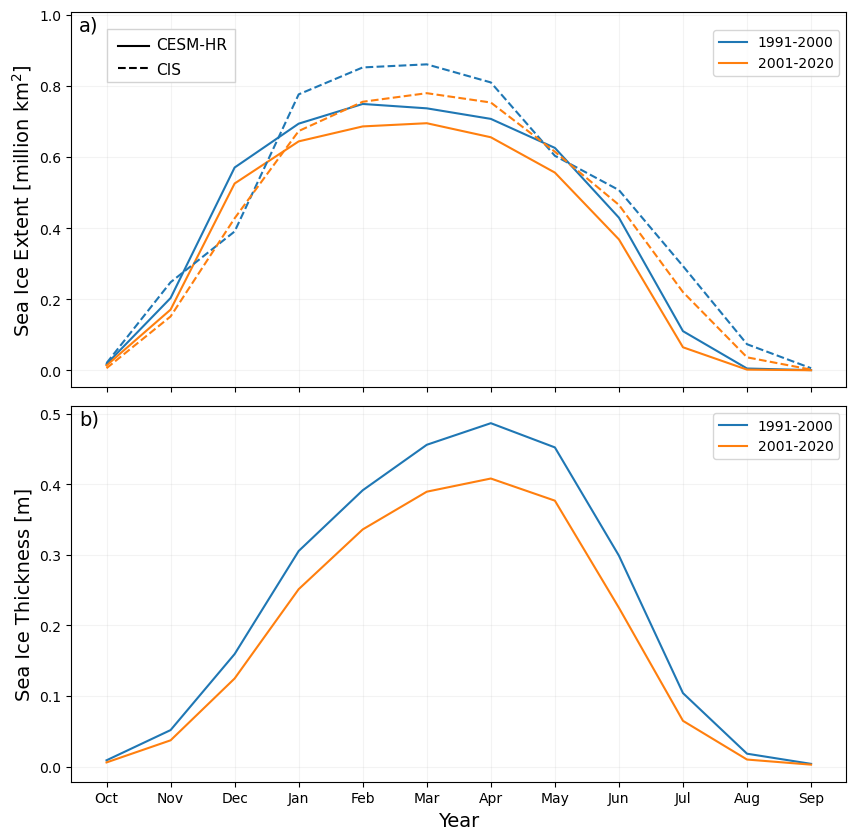

In [41]:
###article

#start_time = time.time()
fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

model_cis_dt = [model_1991_00_monthly, model_2001_20_monthly, cis_1991_00_monthly, cis_2001_20_monthly]

hi_dt =[model_hi_1991_00_monthly, model_hi_2001_20_monthly]


cl = ['tab:blue', 'tab:orange', 'tab:blue', 'tab:orange']
month_dt = ['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug', 'Sep']
lb = ['1991-2000', '2001-2020']

# First plot
for i in range (len(model_cis_dt)):
    if i <2:
        ls='-'
        ax[0].plot(month_dt, np.append(model_cis_dt[i][9:], model_cis_dt[i][:9]), linestyle=ls, color=cl[i], label=lb[i])
        #ax[0].fill_between(month_dt, np.append(mc_data_mn[i][9:],mc_data_mn[i][:9]),
                           #np.append(mc_data_mx[i][9:],mc_data_mx[i][:9]),color=cl[i], alpha=0.03)
        ax[0].legend(loc='upper right', bbox_to_anchor=(1.0,0.97))
        
    if i >=2:
        ls='--'
        ax[0].plot(month_dt, np.append(model_cis_dt[i][9:], model_cis_dt[i][:9]), linestyle=ls, color=cl[i])
        #ax[0].fill_between(month_dt, np.append(mc_data_mn[i][9:],mc_data_mn[i][:9]),
                           #np.append(mc_data_mx[i][9:],mc_data_mx[i][:9]),color=cl[i], alpha=0.03)
        
    ax[0].set_ylabel('Sea Ice Extent [million km$^2$]', fontsize=14)
    ax[0].grid(alpha=0.15)
    
                 
# Second plot  
for i in range (len(hi_dt)):
    ls='-'
    ax[1].plot(month_dt, np.append(hi_dt[i][9:], hi_dt[i][:9]), linestyle=ls, color=cl[i], label=lb[i])
    #ax[1].fill_between(month_dt, np.append(hi_data_mn[i][9:],hi_data_mn[i][:9]),np.append(hi_data_mx[i][9:],hi_data_mx[i][:9]),
                       #color=cl[i], alpha=0.03)
    ax[1].legend(loc='upper right')
    ax[1].set_ylabel('Sea Ice Thickness [m]', fontsize=14)
    ax[1].set_xlabel('Year', fontsize=14)
    ax[1].grid(alpha=0.15)  

rectangle = patches.Rectangle((0.005, 0.81), 2, 0.15, edgecolor='lightgray',  facecolor='white',linewidth=1, zorder=10)
ax[0].add_patch(rectangle)

# Add CESM-HR text and line
ax[0].text(0.11, 0.9, 'CESM-HR', transform=ax[0].transAxes, fontsize=11, zorder=11)
ax[0].plot([0.06, 0.1], [0.91, 0.91], color='black', transform=ax[0].transAxes, linestyle='-', zorder=11)

# Add CIS text and dashed line
ax[0].text(0.11, 0.835, 'CIS', transform=ax[0].transAxes, fontsize=11, zorder=11)
ax[0].plot([0.06, 0.1], [0.85, 0.85], color='black', transform=ax[0].transAxes, linestyle='--', zorder=11)

    
ax[0].text(0.01, 0.95, 'a)',transform=ax[0].transAxes,  fontsize=14)
ax[1].text(0.01, 0.95, 'b)',transform=ax[1].transAxes,  fontsize=14)


plt.subplots_adjust(hspace=0.05)
plt.savefig('/storage2/tkyeimiah/Plots/new-Fig4.jpg', dpi=500, bbox_inches='tight')
plt.show()

### Fig 3

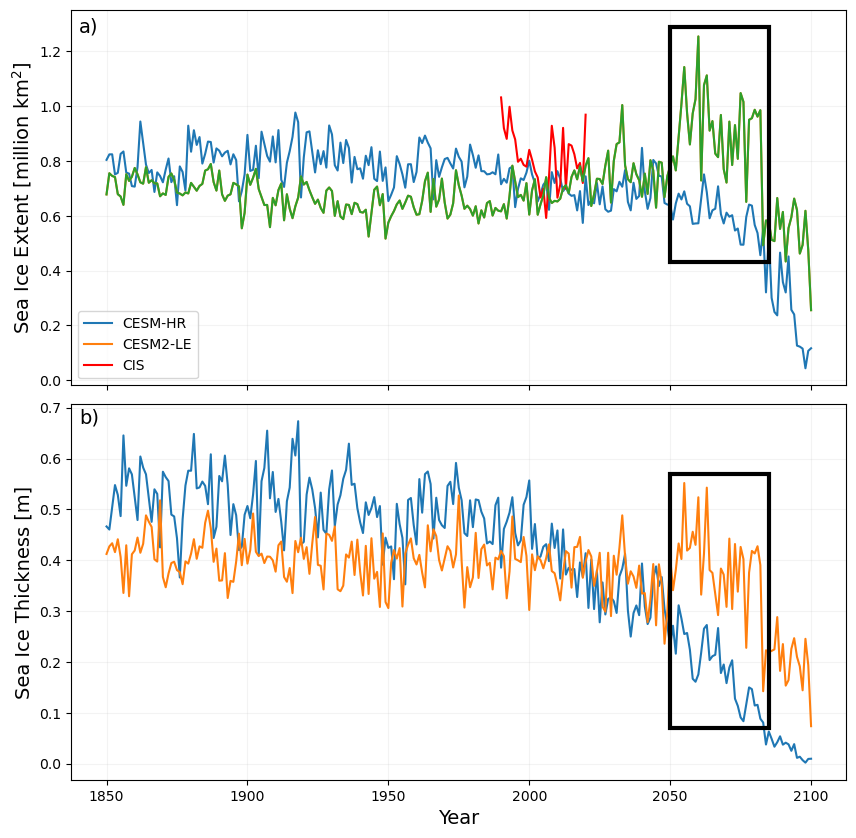

Execution time:  0.0 hours, 0.0 minutes, 0.05403494834899902 seconds


In [42]:

# SIE  : CESM-HR
march_aice_hist = aice_hist_region.sel(time=slice('1850','2005'))[2::12].sum(('nj', 'ni'))
march_aice_proj = aice_proj_region.sel(time=slice('2006','2100'))[2::12].sum(('nj', 'ni'))
march_aice=xr.concat([march_aice_hist,march_aice_proj], dim='time')

# SIE : CIS
obs_SIE=obs_CT_region.sel(time=slice('1990','2020'))
obs_SIE_march=obs_SIE[2::12].sum(['rlat','rlon'])

# SIE  : LR-CESM
march_aice_LR = aice_lr_region.sel(time=slice('1850','2100'))[2::12].sum(('nj', 'ni'))


# SIT : CESM-HR
march_hi_hist = hi_hist_region1.sel(time=slice('1850','2005'))[3::12].mean(('nj', 'ni'))
march_hi_proj = hi_proj_region1.sel(time=slice('2006','2100'))[3::12].mean(('nj', 'ni'))
march_hi=xr.concat([march_hi_hist,march_hi_proj], dim='time')

# SIT  : LR-CESM
march_hi_LR= hi_lr_region.sel(time=slice('1850','2100'))[3::12].mean(('nj', 'ni'))


fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
years =np.arange(1850,2101,1)
#yearss =np.arange(1850,2101)

# First plot              
ax[0].plot(years, march_aice, label='CESM-HR')
ax[0].plot(years, march_aice_LR, label='CESM2-LE')
ax[0].plot(np.arange(1990,2021), obs_SIE_march, color='red', label='CIS')
ax[0].set_ylabel('Sea Ice Extent [million km$^2$]', fontsize=14)
ax[0].grid(alpha=0.15)
ax[0].legend(loc='lower left')               
# Second plot         
ax[1].plot(years, march_hi.fillna((0.08338354+0.1498341)/2), label='CESM-HR')
ax[1].plot(years, march_hi_LR, label='CESM2-LE')
ax[1].set_ylabel('Sea Ice Thickness [m]', fontsize=14)
ax[1].grid(alpha=0.15)
#
ax[1].set_xlabel('Year', fontsize=14)

ax[0].text(0.01, 0.94, 'a)',transform=ax[0].transAxes,  fontsize=14)
ax[1].text(0.01, 0.95, 'b)',transform=ax[1].transAxes,  fontsize=14)

ax[0].plot(years, march_aice_LR, label='CESM2-LE')
rect=ax[0].add_patch(Rectangle((2050, 0.43), 35, 0.86, edgecolor='black',facecolor='none',lw=3,))
rect.set_zorder(10)
rect1=ax[1].add_patch(Rectangle((2050, 0.07), 35, 0.5, edgecolor='black',facecolor='none',lw=3,))
rect1.set_zorder(10)

plt.subplots_adjust(hspace=0.05)
plt.savefig('/storage2/tkyeimiah/Plots/new-Fig2a.jpg', dpi=500, bbox_inches='tight')
plt.show()

print("Execution time: ", hours, "hours,", minutes, "minutes,", seconds, "seconds")


### Fig 4

In [43]:
cis_sic_1991_00 = obs_CT_resampled.sel(time=slice('1991', '2000'))
cis_sic_2001_20 = obs_CT_resampled.sel(time=slice('2001', '2020'))
cis_sic_1991_00_=cis_sic_1991_00[2::12].mean('time').fillna(0)*100
cis_sic_2001_20_=cis_sic_2001_20[2::12].mean('time').fillna(0)*100

model_sic_1991_00_=model_sic_1991_00[2::12].mean('time')
model_sic_2001_20_=model_sic_2001_20[2::12].mean('time')
model_sic_2041_60_=model_sic_2041_60[2::12].mean('time')
model_sic_2081_100_=model_sic_2081_100[2::12].mean('time')

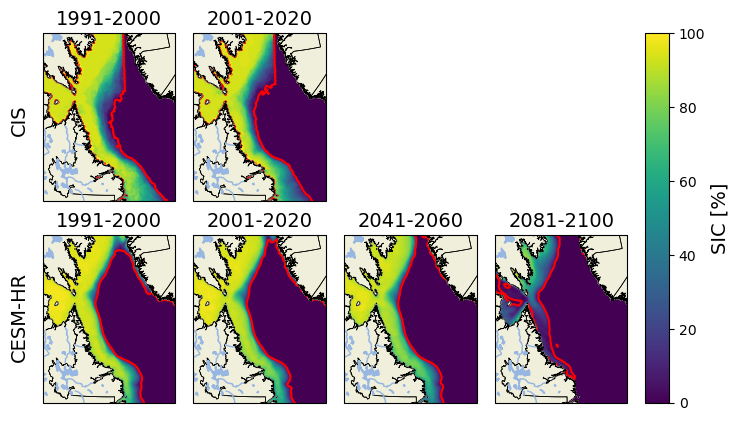

Execution time:  0.0 hours, 1.0 minutes, 13.093837022781372 seconds


In [44]:
#=========sic_region==max========================

fig = plt.figure(figsize=(8,4.8))
sic_data = [cis_sic_1991_00_, cis_sic_2001_20_,
            model_sic_1991_00_, model_sic_2001_20_, model_sic_2041_60_, model_sic_2081_100_]

#hi_data1 = [model_hi_1991_00, model_hi_2000_20, model_hi_2040_60, model_hi_2080_100]
titles = ['1991-2000', '2001-2020', '1991-2000', '2001-2020', '2041-2060', '2081-2100' ]


norm = plt.Normalize(0, 100)
cb=cm.ScalarMappable(norm=norm)


x0, x1, y0, y1 =-68,-48,51,67

# Calculate the central longitude and latitude
c_lon = (x0 + x1) / 2
c_lat = (y0 + y1) / 2
subplot_positions = [1, 2, 5, 6, 7, 8]
for i, v in enumerate(sic_data):
#for i in range(3):
    # Create a subplot with the PlateCarree projection
    ax = plt.subplot(2,4, subplot_positions[i],projection=ccrs.AlbersEqualArea(central_longitude=c_lon, 
                                                              central_latitude=c_lat,standard_parallels=(y0, y1)))
    ax.set_title(titles[i], fontsize=14)
    ax.coastlines(zorder=2)
    ax.add_feature(cfeature.LAND, zorder=2)
    ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5,  zorder=2)
    ax.add_feature(cfeature.LAKES.with_scale('10m'),  zorder=2)
    ax.add_feature(cfeature.RIVERS.with_scale('10m'),  zorder=2)
    ax.set_extent([x0, x1, y0, y1])
    #ax.text(0,1.05,letter[i], transform=ax.transAxes, fontsize=9)
    
    if i in [0,1]:
        contf=ax.contourf(sic_data[i].lon, sic_data[i].lat, sic_data[i],vmin=15,levels=100,
                           transform=ccrs.PlateCarree(), zorder=1)
        ax.contour(sic_data[i].lon, sic_data[i].lat, sic_data[i], levels=[15],  colors='red', 
                   linewidth=5, transform=ccrs.PlateCarree(), zorder=1)
        
    if i in [2,3,4,5]:
        contf=ax.contourf(sic_data[i].TLON, sic_data[i].TLAT, sic_data[i], vmin=15,
                          levels=100,transform=ccrs.PlateCarree(), zorder=1)
        ax.contour(sic_data[i].TLON, sic_data[i].TLAT, sic_data[i],levels=[15],norm=norm,colors='red',linewidth=5,
               transform=ccrs.PlateCarree(), zorder=1)
   
    
    
cbar_ax = fig.add_axes([0.9, 0.11, 0.03, 0.77])
cbar=fig.colorbar(cb, cax=cbar_ax, ax=ax, orientation='vertical',label='SIC [%]')
cbar.ax.tick_params(labelsize=10)
cbar.ax.set_ylabel('SIC [%]', fontsize=14)  

name=['CIS','CESM-HR']
x=[0.13,0.13]
y=[0.7,0.29]
for i in range (2):
    fig.text(x[i],y[i], name[i], va='bottom', ha='center', rotation='vertical',
             rotation_mode='anchor',fontsize=14)
plt.subplots_adjust(wspace=-0.1)
#plt.subplots_adjust(hspace=0.7)
plt.savefig('/storage2/tkyeimiah/Plots/new-Fig3.jpg',dpi=500, bbox_inches='tight')
plt.show()


end_time = time.time()
elapsed_time = end_time - start_time
hours, remainder = divmod(elapsed_time, 3600)
minutes, seconds = divmod(remainder, 60)
print("Execution time: ", hours, "hours,", minutes, "minutes,", seconds, "seconds")
    
    
    

plt.show()

### Fig 5

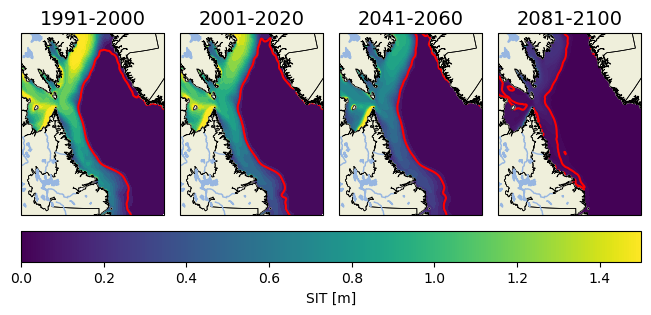

In [45]:
#=========sic_region==max========================
fig = plt.figure(figsize=(8,2.4))
sic_data = [model_sic_1991_00_, model_sic_2001_20_, model_sic_2041_60_, model_sic_2081_100_]

hi_data1 = [model_hi_1991_00b, model_hi_2001_20b, model_hi_2041_60b, model_hi_2081_100b]
titles = ['1991-2000', '2001-2020', '2041-2060', '2081-2100',]

global_min = np.min([np.nanmin(data.max('time').values) for data in hi_data1])
#global_max = np.max([np.nanmax(data.max('time').values) for data in hi_data1])
norm = plt.Normalize(vmin=global_min, vmax=1.5)
cb=cm.ScalarMappable(norm=norm)

x0, x1, y0, y1 =-68,-48,51,67
  
# Calculate the central longitude and latitude
c_lon = (x0 + x1) / 2
c_lat = (y0 + y1) / 2
for i, v in enumerate(sic_data):
#for i in range(3):
    # Create a subplot with the PlateCarree projection
    ax = plt.subplot(1,4, i+1,projection=ccrs.AlbersEqualArea(central_longitude=c_lon, 
                                                              central_latitude=c_lat,standard_parallels=(y0, y1)))
    ax.set_title(titles[i], fontsize=14)
    ax.coastlines(zorder=2)
    ax.add_feature(cfeature.LAND, zorder=2)
    ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5,  zorder=2)
    ax.add_feature(cfeature.LAKES.with_scale('10m'),  zorder=2)
    ax.add_feature(cfeature.RIVERS.with_scale('10m'),  zorder=2)
    ax.set_extent([x0, x1, y0, y1])
    #ax.text(0,1.05,letter[i], transform=ax.transAxes, fontsize=9)
    
   
    ax.contourf(hi_data1[i].TLON, hi_data1[i].TLAT, hi_data1[i][2::12].mean('time'),levels=45,
                norm=norm, transform=ccrs.PlateCarree(), zorder=1)
    ax.contour(sic_data[i].TLON, sic_data[i].TLAT, sic_data[i],levels=[15],norm=norm,colors='red',linewidth=5,
               transform=ccrs.PlateCarree(), zorder=1)
    #if i in [4,5]:
        #contf=ax.contourf(sic_data[i].lon, sic_data[i].lat, sic_data[i],
                          #levels=45, norm=norm, transform=ccrs.PlateCarree())
    
    
cbar_ax = fig.add_axes([0.125, -0.08, 0.775, 0.13])
cbar=fig.colorbar(cb, cax=cbar_ax, ax=ax, orientation='horizontal', label='SIT [m]')
cbar.ax.tick_params(labelsize=10)
cbar.ax.set_ylabel('SIT [m]', fontsize=14)  


plt.subplots_adjust(wspace=0.11)
#plt.subplots_adjust(hspace=0.7)
plt.savefig('/storage2/tkyeimiah/Plots/new-Fig6a.jpg',dpi=500, bbox_inches='tight')
plt.show()

### Fig 6

In [46]:
hi_month_1990_2005=hi_hist_region.sel(time=slice('1990-01-01','2005-12-31'))
hi_month_2006_2020=hi_proj_region.sel(time=slice('2006-01-01','2020-12-31'))
hi_region_1990_2020=xr.concat((hi_month_1990_2005,hi_month_2006_2020 ), dim='time')
hi_months=hi_region_1990_2020.groupby('time.month').mean('time')

In [47]:
#plot for article
sic_month_1990_2005 = aice_hist_region_.sel(time=slice('1990-01-01','2005-12-31'))
sic_month_2006_2020 = aice_proj_region_.sel(time=slice('2006-01-01','2020-12-31'))
sic_region_1990_2020= xr.concat([sic_month_1990_2005, sic_month_2006_2020], dim='time')
sic_months=sic_region_1990_2020.groupby('time.month').mean('time')

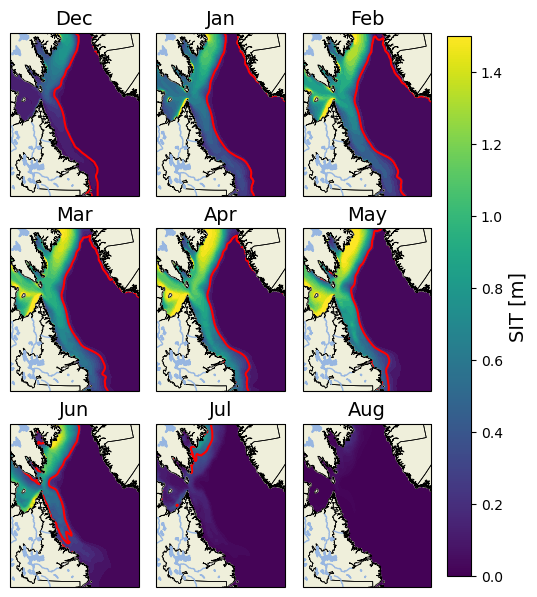

In [48]:
fig = plt.figure(figsize=(6, 7.2))

selected_data= [hi_months[11], hi_months[0], hi_months[1], hi_months[2], hi_months[3], hi_months[4], hi_months[5], hi_months[6],hi_months[7]]
selected_data1=[sic_months[11],sic_months[0],sic_months[1],sic_months[2],sic_months[3], sic_months[4], sic_months[5],sic_months[6],sic_months[7]]


titles = ['Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug']
#name=['a)','b)','c)','d)','e)','f)','g)','h)','i)']

global_min = np.min([np.nanmin(data.values) for data in selected_data])
global_max = np.max([np.nanmax(data.values) for data in selected_data])
norm = plt.Normalize(vmin=global_min, vmax=1.5)
cb=cm.ScalarMappable(norm=norm)

x0, x1, y0, y1 =-68,-48,51,67


# Calculate the central longitude and latitude
c_lon = (x0 + x1) / 2
c_lat = (y0 + y1) / 2
for i, v in enumerate(selected_data):
    ax = plt.subplot(3,3, i+1,projection=ccrs.AlbersEqualArea(central_longitude=c_lon, 
                                                              central_latitude=c_lat,standard_parallels=(y0, y1)))
    
    ax.set_title(titles[i], fontsize=14)
    ax.coastlines(zorder=2)
    ax.add_feature(cfeature.LAND, zorder=2)
    ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5,  zorder=2)
    ax.add_feature(cfeature.LAKES.with_scale('10m'),  zorder=2)
    ax.add_feature(cfeature.RIVERS.with_scale('10m'),  zorder=2)
    #ax.add_feature(cfeature.BORDERS,  zorder=2)
    
    
    ax.set_extent([x0, x1, y0, y1])
    #ax.text(0,1.05,name[i], transform=ax.transAxes, fontsize=14)
    ax.contourf(selected_data[i].TLON, selected_data[i].TLAT, selected_data[i], levels=45, norm=norm,
                   transform=ccrs.PlateCarree(), )
    ax.contour(selected_data1[i].TLON, selected_data1[i].TLAT, selected_data1[i], levels=[15], norm=norm, colors='red',
               linewidth=5, transform=ccrs.PlateCarree(), zorder=1)
    
cbar_ax = fig.add_axes([0.89, 0.125, 0.04, 0.75])
cbar=fig.colorbar(cb, cax=cbar_ax, ax=ax, orientation='vertical')
cbar.ax.tick_params(labelsize=10)
cbar.ax.set_ylabel('SIT [m]', fontsize=14)  

plt.subplots_adjust(wspace=-0.15)
plt.savefig('/storage2/tkyeimiah/Plots/new-Fig7a.jpg',dpi=500, bbox_inches='tight')
plt.show()

### Fig 7

In [49]:
model_SIE_hist =aice_hist_region.sel(time=slice('1990-01-01','2005-12-31'))
model_SIE_proj =aice_proj_region.sel(time=slice('2006-01-01','2020-12-31'))
model_SIE= xr.concat([model_SIE_hist, model_SIE_proj], dim='time')

obs_SIE=obs_CT_region.sel(time=slice('1990-01-01','2020-12-31'))

model_SIE_march=model_SIE[2::12].sum(('nj', 'ni'))
obs_SIE_march=obs_SIE[2::12].sum(['rlat','rlon'])

In [50]:
np.mean(model_SIE_march.values-obs_SIE_march.values)

-0.10454435602355082

# Plot of the obs and model from 1990 to 2018
fig, ax=plt.subplots(figsize=(10,4))
start_time=time.time()

ax.plot(np.arange(1990,2021), model_SIE_march, label='CESM-HR', color='tab:blue', )
ax.plot(np.arange(1990,2021), obs_SIE_march, color='orange', label='CIS')
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Sea Ice Extent [million km$^2$]', fontsize=14)
ax.set_ylim(0,1.3)
ax.legend()
ax.grid(alpha=0.15)
#plt.xlim(1990,2021)

plt.savefig('/storage2/tkyeimiah/Plots/Fig7-old.jpg',dpi=500, bbox_inches='tight') 
plt.show()


end_time=time.time()
elapsed_time = end_time - start_time
hours, remainder = divmod(elapsed_time, 3600)
minutes, seconds = divmod(remainder, 60)
print("Execution time: ", hours, "hours,", minutes, "minutes,", seconds, "seconds")

### Fig 9

In [51]:
obs_months=obs_CT_sel.groupby('time.month').mean('time')
model_months=model_CT_sel.groupby('time.month').mean('time')

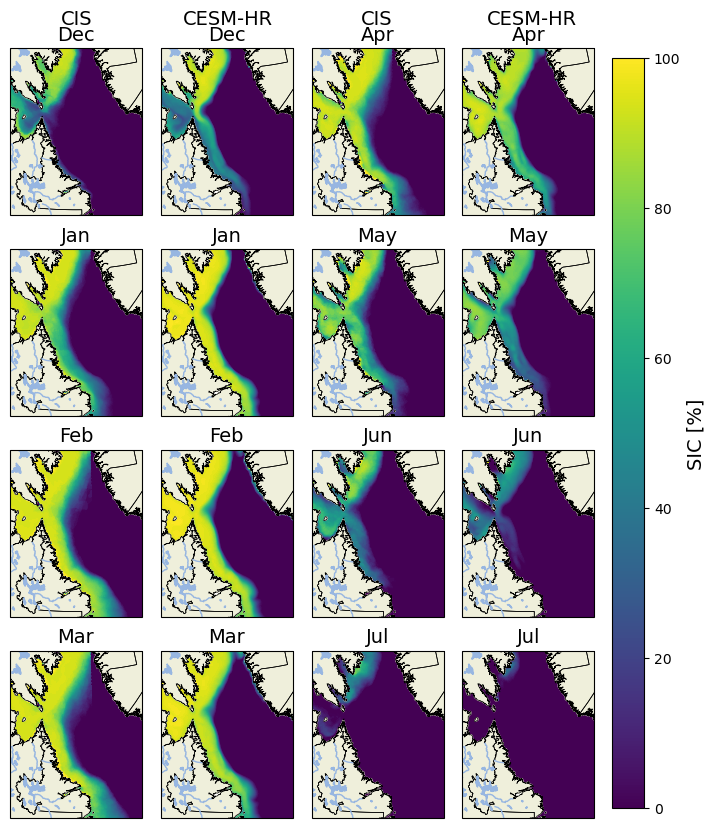

Execution time:  0.0 hours, 1.0 minutes, 34.97465634346008 seconds


In [52]:
start_time = time.time()
#fig = plt.figure(figsize=(8, 4.8))
fig = plt.figure(figsize=(8,10))
obs_data=[obs_months[-1],obs_months[3], obs_months[0],obs_months[4], obs_months[1],obs_months[5],
          obs_months[2],obs_months[6]]

model_data=[model_months[-1],model_months[3], model_months[0],model_months[4], model_months[1],model_months[5],
            model_months[2],model_months[6]]

titles = ['Dec','Apr','Jan','May','Feb','Jun','Mar','Jul',]
#name=['a)','c)','e)','g)','i)','k)','m)','o)','q)']
#name1=['b)','d)','f)','h)','j)','l)','n)','p)','r)']

norm = plt.Normalize(0, 100)
cb=cm.ScalarMappable(norm=norm)

x0, x1, y0, y1 =-68,-48,51,67

# Calculate the central longitude and latitude
c_lon = (x0 + x1) / 2
c_lat = (y0 + y1) / 2
for i in range(16):
    index = i // 2 
    
    if i % 2 == 0:
        ax = plt.subplot(4, 4, i+1, projection=ccrs.AlbersEqualArea(central_longitude=c_lon,
                                                                     central_latitude=c_lat,
                                                                     standard_parallels=(y0, y1)))
        ax.set_title(titles[index], fontsize=14)
        ax.add_feature(cfeature.LAND, zorder=2)
        ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5, zorder=2)
        ax.add_feature(cfeature.LAKES.with_scale('10m'), zorder=2)
        ax.add_feature(cfeature.RIVERS.with_scale('10m'), zorder=2)
        ax.set_extent([x0, x1, y0, y1])
        ax.contourf(obs_data[index].lon, obs_data[index].lat, obs_data[index].fillna(0)*100, vmin=15,levels=100,
                    transform=ccrs.PlateCarree())
        #ax.text(0,1.05,name[index], transform=ax.transAxes, fontsize=14)
        
    else:
        ax = plt.subplot(4, 4, i+1, projection=ccrs.AlbersEqualArea(central_longitude=c_lon,
                                                                     central_latitude=c_lat,
                                                                     standard_parallels=(y0, y1)))
        if index < len(model_data):
            ax.set_title(titles[index], fontsize=14)
            ax.add_feature(cfeature.LAND, zorder=2)
            ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5, zorder=2)
            ax.add_feature(cfeature.LAKES.with_scale('10m'), zorder=2)
            ax.add_feature(cfeature.RIVERS.with_scale('10m'), zorder=2)
            ax.set_extent([x0, x1, y0, y1])
            ax.contourf(model_data[index].TLON, model_data[index].TLAT, model_data[index], levels=100,
                        vmin=15, transform=ccrs.PlateCarree(), zorder=1)
            #ax.text(0,1.05,name1[index], transform=ax.transAxes, fontsize=14)

cbar_ax = fig.add_axes([0.9, 0.12, 0.04, 0.75])
cbar=fig.colorbar(cb, cax=cbar_ax, ax=ax, orientation='vertical',label='SIC [%]')
cbar.ax.tick_params(labelsize=10)
cbar.ax.set_ylabel('SIC [%]', fontsize=14)

name=['CIS', 'CESM-HR','CIS', 'CESM-HR']
x=[0.23, 0.42, 0.605, 0.8]
y=[0.9,0.9,0.9,0.9]
for i in range (4):
    fig.text(x[i],y[i], name[i], va='bottom', ha='center', rotation='horizontal',
             rotation_mode='anchor',fontsize=14)


plt.subplots_adjust(wspace=-0.1)
plt.savefig('/storage2/tkyeimiah/Plots/new-Fig5.jpg',dpi=500, bbox_inches='tight')
plt.show()



end_time = time.time()
elapsed_time = end_time - start_time
hours, remainder = divmod(elapsed_time, 3600)
minutes, seconds = divmod(remainder, 60)
print("Execution time: ", hours, "hours,", minutes, "minutes,", seconds, "seconds")

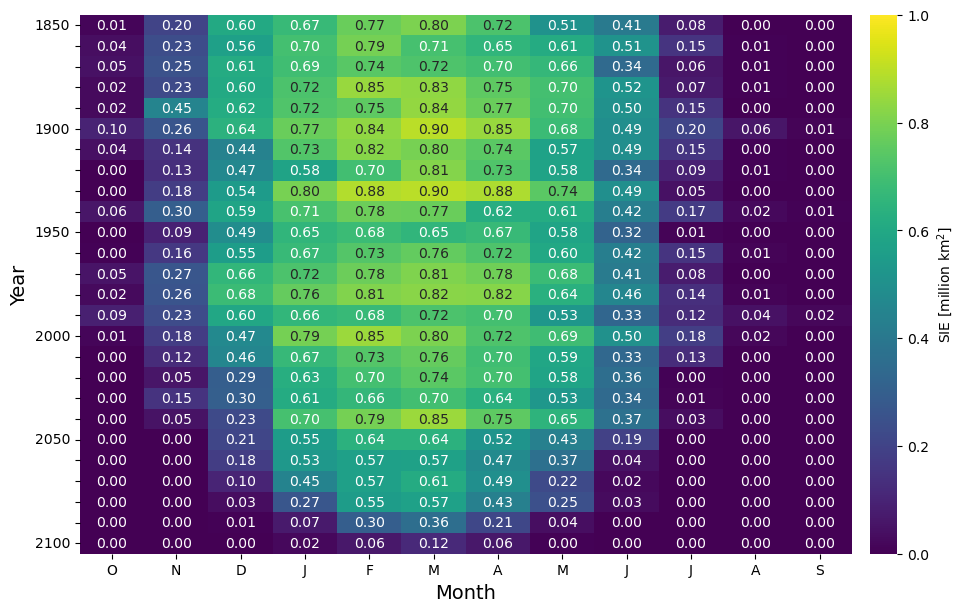

In [53]:
# Convert this DataArray to a DataFrame
aice1 = aice_hist_region.sel(time=slice('1850-01-01','2005-12-31'))
aice2 = aice_proj_region.sel(time=slice('2006-01-01','2100-12-31'))
aice3 = xr.concat([aice1, aice2], dim='time') 

ds_mean = aice3.sum(dim=['nj', 'ni'], skipna=True)
df = ds_mean.to_dataframe(name='SIE')

# Reset the index so that 'time' becomes a column
df.reset_index(inplace=True)

# Extract the year and month from the 'time' column
df['Year'] = [date.year for date in df['time']]
df['Month'] = [date.month for date in df['time']]

# Map numeric month to month name
month_dict = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 
              6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 
              11: 'Nov', 12: 'Dec'}

df['Month'] = df['Month'].map(month_dict)

# Define custom sorting order for the months
custom_order = ['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar',
                'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']

# Convert 'month' to categorical data type with custom order
df['Month'] = pd.Categorical(df['Month'], categories=custom_order, ordered=True)

# Filter rows for the specified years
selected_years = np.arange(1850,2101,10)
df_all = df[df['Year'].isin(selected_years)]

# Create a pivot table with 'year' as rows, 'month' as columns, and mean 'aice' as values
pivot_df = df_all.pivot('Year', 'Month', 'SIE')

custom_order1 = ['O', 'N', 'D', 'J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S']

# Plot the heatmap
plt.figure(figsize=(12, 7))
sns.heatmap(pivot_df,  cmap="viridis", annot=True, fmt='.2f', vmin=0, vmax=1, cbar=True,
            cbar_kws={'label':'SIE [million km$^2$]',
                      'pad':0.02})

plt.xticks(np.arange(0.5,12.5),custom_order1)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Year', fontsize=14)

# Specify the years you want to label
labelled_years = [1850, 1900, 1950, 2000, 2050, 2100]
# Create y-ticks for all years but set labels only for specified years
plt.yticks(np.arange(len(pivot_df.index)) + 0.5, 
           [str(year) if year in labelled_years else '' for year in pivot_df.index])
plt.ylabel('Year', fontsize=14)

#plt.savefig('/storage2/tkyeimiah/Plots/new-Fig9.jpg',dpi=500, bbox_inches='tight')
plt.savefig('/storage2/tkyeimiah/Plots/Fig7.jpg',dpi=500, bbox_inches='tight')
plt.show()

In [54]:
# heat_map function

def heat_map(data, source):
    if source=='model':
        ds_mean = data.sum(dim=['nj', 'ni'], skipna=True)
        df = ds_mean.to_dataframe(name='SIE')
    elif source=='obs':
        ds_mean = data.sum(dim=['rlat', 'rlon'], skipna=True)
        df = ds_mean.to_dataframe(name='SIE')

    # Reset the index so that 'time' becomes a column
    df.reset_index(inplace=True)

    # Extract the year and month from the 'time' column
    df['Year'] = [date.year for date in df['time']]
    df['Month'] = [date.month for date in df['time']]

    # Map numeric month to month name
    month_dict = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
                  7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

    df['Month'] = df['Month'].map(month_dict)
    
    # Define custom sorting order for the months
    custom_order = ['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar','Apr',
                    'May', 'Jun', 'Jul', 'Aug', 'Sep']

    # Convert 'month' to categorical data type with custom order
    df['Month'] = pd.Categorical(df['Month'], categories=custom_order, ordered=True)

    # Filter rows for the specified years
    selected_years = np.arange(1990,2021,3)
    df_all = df[df['Year'].isin(selected_years)]

    # Create a pivot table with 'year' as rows, 'month' as columns, and mean 'aice' as values
    pivot_df = df_all.pivot('Year', 'Month', 'SIE')
    return pivot_df

In [55]:
#using the function
model_SIE_pivot=heat_map(model_SIE, 'model')
obs_SIE_pivot=heat_map(obs_SIE, 'obs')

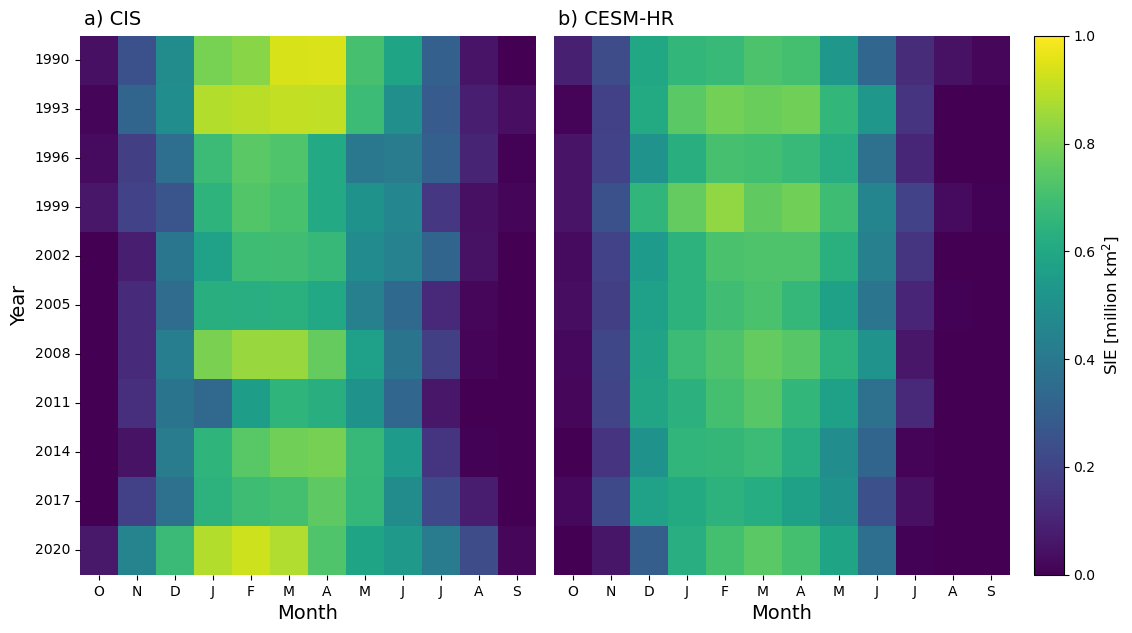

In [56]:
import matplotlib.colors as mcolors
import matplotlib.colorbar as mcolorbar
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,7),  gridspec_kw={'width_ratios':[1,1]}) #10-5

g1 = sns.heatmap(obs_SIE_pivot,  vmax=1.1, cmap="viridis", cbar=False, ax=ax1)
g1.set_ylabel('Year', fontsize=14)
g1.set_xlabel('Month', fontsize=14)
g1.text(0.01, 1.02, 'a) CIS',transform=ax1.transAxes,  fontsize=14)

custom_order1 = ['O', 'N', 'D', 'J', 'F', 'M','A',
                    'M', 'J', 'J', 'A', 'S']

g2 = sns.heatmap(model_SIE_pivot,  vmax=1,cbar=False, cmap="viridis", ax=ax2)
#colorbar = g2.collections[0].colorbar
#colorbar.ax.yaxis.label.set_size(13)  # Set the font size here
g2.set_ylabel('')
g2.set_xlabel('Month', fontsize=14)
g2.set_yticks([])
g2.text(0.01, 1.02, 'b) CESM-HR',transform=ax2.transAxes, fontsize=14)

for ax in [g1,g2]:
    tl = ax.get_xticklabels()
    ax.set_xticklabels(custom_order1)
    tly = ax.get_yticklabels()
    ax.set_yticklabels(tly, rotation=0)

axcb = fig.add_axes([0.92, 0.11, 0.025, 0.77])

# Create a colormap and a normalize object
cmap = sns.color_palette("viridis", as_cmap=True)
norm = mcolors.Normalize(vmin=0, vmax=1)

# Create the colorbar
cb1 = mcolorbar.ColorbarBase(axcb, cmap=cmap, norm=norm, orientation='vertical',)
cb1.set_label('SIE [million km$^2$]')
cb1.ax.yaxis.label.set_size(12)    
    
plt.subplots_adjust(wspace=0.04)  
plt.savefig('/storage2/tkyeimiah/Plots/new-Fig8.jpg',dpi=500, bbox_inches='tight')
plt.show()

### CDR

In [57]:
path_cdr='/storage2/tkyeimiah/CDR/'

In [58]:
cdr=xr.open_dataset(path_cdr+'CDR_CT.nc')
cdr

<xarray.Dataset>
Dimensions:                  (tdim: 372, x: 304, y: 448)
Coordinates:
  * tdim                     (tdim) datetime64[ns] 1990-01-01 ... 2020-12-01
  * x                        (x) float64 -3.838e+06 -3.812e+06 ... 3.738e+06
  * y                        (y) float64 5.838e+06 5.812e+06 ... -5.338e+06
Data variables:
    cdr_seaice_conc_monthly  (tdim, y, x) float32 ...

In [59]:
cdr_CT=cdr.cdr_seaice_conc_monthly

In [60]:
# Extract the x and y grid coordinates
xgrid = cdr_CT.x.values
ygrid = cdr_CT.y.values

# Create a meshgrid of x and y coordinates
x, y = np.meshgrid(xgrid, ygrid)

# Define the projection used by the xgrid and ygrid (EPSG:3411)
proj_stereo = Proj(init='EPSG:3411')

# Define the projection for latitude and longitude
proj_latlon = Proj(proj='latlong', datum='WGS84')

# Transform the grid coordinates to latitude and longitude
lon, lat = transform(proj_stereo, proj_latlon, x, y)

# Create DataArrays for lon and lat to use xarray's slicing
lon_da = xr.DataArray(lon, dims=('y', 'x'))
lat_da = xr.DataArray(lat, dims=('y', 'x'))

# Define the Labrador coast boundaries
lon_min, lon_max = -73, -45  # Converted from 287 to 315 degrees to -73 to -45 degrees
lat_min, lat_max = 51, 69

# Subset the data using the domain mask
domain_mask = (lon_da >= lon_min) & (lon_da <= lon_max) & (lat_da >= lat_min) & (lat_da <= lat_max)
cdr_CT_subset = cdr_CT.where(domain_mask, drop=True)
cdr_CT_domain = cdr_CT_subset.where(cdr_CT_subset <= 1)
# Subset lon and lat accordingly
lon_subset = lon_da.where(domain_mask, drop=True)
lat_subset = lat_da.where(domain_mask, drop=True)

In [61]:
cdr_sic_1991_00 = cdr_CT_domain.sel(tdim=slice('1991', '2000'))
cdr_sic_2001_20 = cdr_CT_domain.sel(tdim=slice('2001', '2020'))
cdr_sic_1991_00_= cdr_sic_1991_00[2::12].mean('tdim')*100
cdr_sic_2001_20_= cdr_sic_2001_20[2::12].mean('tdim')*100

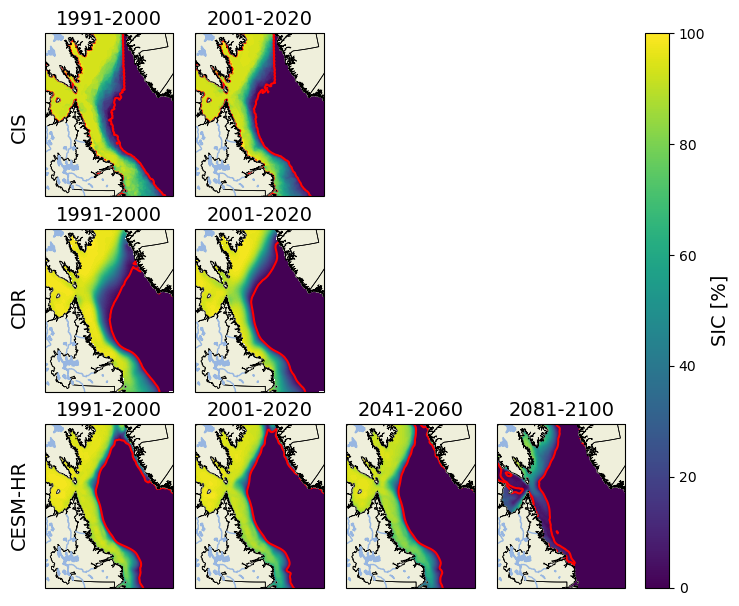

In [62]:
#=========sic_region==max========================

fig = plt.figure(figsize=(8,7.2))
sic_data = [cis_sic_1991_00_, cis_sic_2001_20_,cdr_sic_1991_00_, cdr_sic_2001_20_, 
            model_sic_1991_00_, model_sic_2001_20_, model_sic_2041_60_, model_sic_2081_100_]

#hi_data1 = [model_hi_1991_00, model_hi_2000_20, model_hi_2040_60, model_hi_2080_100]
titles = ['1991-2000', '2001-2020', '1991-2000', '2001-2020', '1991-2000', '2001-2020', '2041-2060', '2081-2100']


norm = plt.Normalize(0, 100)
cb=cm.ScalarMappable(norm=norm)


x0, x1, y0, y1 =-68,-48,51,67

# Calculate the central longitude and latitude
c_lon = (x0 + x1) / 2
c_lat = (y0 + y1) / 2
subplot_positions = [1, 2, 5, 6, 9,10,11,12]
for i, v in enumerate(sic_data):
#for i in range(3):
    # Create a subplot with the PlateCarree projection
    ax = plt.subplot(3,4, subplot_positions[i],projection=ccrs.AlbersEqualArea(central_longitude=c_lon, 
                                                              central_latitude=c_lat,standard_parallels=(y0, y1)))
    ax.set_title(titles[i], fontsize=14)
    ax.coastlines(zorder=2)
    ax.add_feature(cfeature.LAND, zorder=2)
    ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5,  zorder=2)
    ax.add_feature(cfeature.LAKES.with_scale('10m'),  zorder=2)
    ax.add_feature(cfeature.RIVERS.with_scale('10m'),  zorder=2)
    ax.set_extent([x0, x1, y0, y1])
    #ax.text(0,1.05,letter[i], transform=ax.transAxes, fontsize=9)
    
    if i in [0,1]:
        contf=ax.contourf(sic_data[i].lon, sic_data[i].lat, sic_data[i],vmin=15,levels=100,
                           transform=ccrs.PlateCarree(), zorder=1)
        ax.contour(sic_data[i].lon, sic_data[i].lat, sic_data[i], levels=[15],  colors='red', 
                   linewidth=5, transform=ccrs.PlateCarree(), zorder=1)
        
    if i in [2,3]:
        contf=ax.contourf(lon_subset,lat_subset,sic_data[i],vmin=15, levels=100,
                          transform=ccrs.PlateCarree(), zorder=1)
        ax.contour(lon_subset,lat_subset,sic_data[i],levels=[15],norm=norm,colors='red',linewidth=5,
               transform=ccrs.PlateCarree(), zorder=1)
        
    if i in [4,5,6,7]:
        contf=ax.contourf(sic_data[i].TLON, sic_data[i].TLAT, sic_data[i], vmin=15,
                          levels=100,transform=ccrs.PlateCarree(), zorder=1)
        ax.contour(sic_data[i].TLON, sic_data[i].TLAT, sic_data[i],levels=[15],norm=norm,colors='red',linewidth=5,
               transform=ccrs.PlateCarree(), zorder=1)
    
   
    
    
cbar_ax = fig.add_axes([0.9, 0.11, 0.03, 0.77])
cbar=fig.colorbar(cb, cax=cbar_ax, ax=ax, orientation='vertical',label='SIC [%]')
cbar.ax.tick_params(labelsize=10)
cbar.ax.set_ylabel('SIC [%]', fontsize=14)  

name=['CIS','CDR','CESM-HR']
x=[0.13,0.13, 0.13]
y=[0.75,0.5, 0.225]
for i in range (3):
    fig.text(x[i],y[i], name[i], va='bottom', ha='center', rotation='vertical',
             rotation_mode='anchor',fontsize=14)
plt.subplots_adjust(wspace=-0.1)
#plt.subplots_adjust(hspace=0.7)
plt.savefig('/storage2/tkyeimiah/Plots/new-Fig3a.jpg',dpi=500, bbox_inches='tight')
plt.show()



### PIOMAS

In [63]:
path_pio='/storage2/tkyeimiah/PIOMAS/PIOMAS'

In [64]:
piomas_data=xr.open_dataset(path_pio+'/heff.nc')
time = pd.date_range('1979-01-01', periods=540, freq='M')
piomas_data['time'] = time

In [65]:
lon_min, lon_max =287, 315 #73W & 45W
lat_min, lat_max =51,69

# Create a mask for Labrador coast 
mask_pio = ((piomas_data.lat_scaler >= lat_min) & (piomas_data.lat_scaler<= lat_max) &
              (piomas_data.lon_scaler >= lon_min) & (piomas_data.lon_scaler <= lon_max))
piomas_data_region=piomas_data.where(mask_pio, drop=True)
piomas_data_region = piomas_data_region.where(piomas_data_region < 9999.9)

In [66]:
piomas_hi=piomas_data_region.heff

In [67]:
#plot for article
piomas_hi_1991_00 = piomas_hi.sel(time=slice('1991','2000'))
piomas_hi_2001_20 = piomas_hi.sel(time=slice('2001','2020'))

piomas_hi_1991_00_monthly = piomas_hi_1991_00.groupby('time.month').mean('time').mean(('y','x'))
piomas_hi_2001_20_monthly = piomas_hi_2001_20.groupby('time.month').mean('time').mean(('y','x'))

piomas_hi_1991_00_monmax = piomas_hi_1991_00.groupby('time.month').max('time').mean(('y','x'))
piomas_hi_2001_20_monmax = piomas_hi_2001_20.groupby('time.month').max('time').mean(('y','x'))

piomas_hi_1991_00_monmin = piomas_hi_1991_00.groupby('time.month').min('time').mean(('y','x'))
piomas_hi_2001_20_monmin = piomas_hi_2001_20.groupby('time.month').min('time').mean(('y','x'))

In [68]:
piomas_1990_2020=piomas_hi.sel(time=slice('1990','2020'))
piomas_hi_months=piomas_1990_2020.groupby('time.month').mean('time')

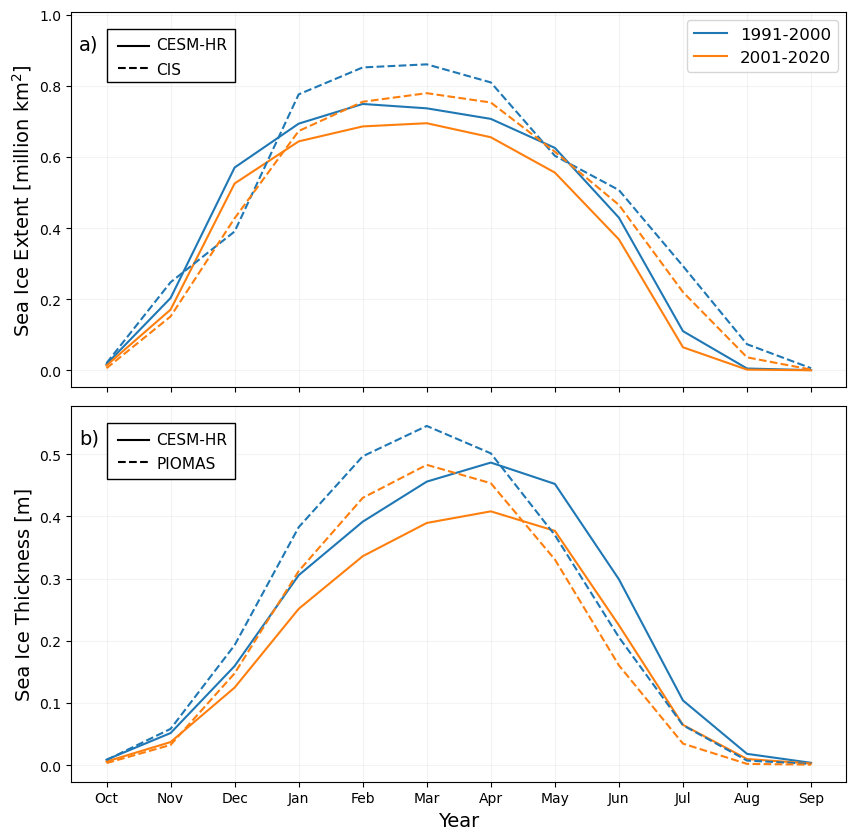

In [69]:

fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

model_cis_dt = [model_1991_00_monthly, model_2001_20_monthly, cis_1991_00_monthly, cis_2001_20_monthly]
mc_data_mx = [model_1991_00_monmax, model_2001_20_monmax, cis_1991_00_monmax, cis_2001_20_monmax]
mc_data_mn = [model_1991_00_monmin, model_2001_20_monmin, cis_1991_00_monmin, cis_2001_20_monmin]

hi_dt =[model_hi_1991_00_monthly, model_hi_2001_20_monthly, piomas_hi_1991_00_monthly, piomas_hi_2001_20_monthly]
hi_data_mx = [model_hi_1991_00_monmax, model_hi_2001_20_monmax, piomas_hi_1991_00_monmax, piomas_hi_2001_20_monmax]
hi_data_mn = [model_hi_1991_00_monmin, model_hi_2001_20_monmin, piomas_hi_1991_00_monmin, piomas_hi_2001_20_monmin]
cl = ['tab:blue', 'tab:orange', 'tab:blue', 'tab:orange']
month_dt = ['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug', 'Sep']
lb = ['1991-2000', '2001-2020']

# First plot
for i in range (len(model_cis_dt)):
    if i <2:
        ls='-'
        ax[0].plot(month_dt, np.append(model_cis_dt[i][9:], model_cis_dt[i][:9]), linestyle=ls, color=cl[i], label=lb[i])
        #ax[0].fill_between(month_dt, np.append(mc_data_mn[i][9:],mc_data_mn[i][:9]),np.append(mc_data_mx[i][9:],mc_data_mx[i][:9]),color=cl[i], alpha=0.1)
        ax[0].legend(loc='upper right',fontsize=12)
        
    if i >=2:
        ls='--'
        ax[0].plot(month_dt, np.append(model_cis_dt[i][9:], model_cis_dt[i][:9]), linestyle=ls, color=cl[i])
        #ax[0].fill_between(month_dt, np.append(mc_data_mn[i][9:],mc_data_mn[i][:9]),np.append(mc_data_mx[i][9:],mc_data_mx[i][:9]),color=cl[i], alpha=0.1)
        
    ax[0].set_ylabel('Sea Ice Extent [million km$^2$]', fontsize=14)
    ax[0].grid(alpha=0.15)
    
                 
# Second plot  
for i in range (len(hi_dt)):
    if i <2:
        ls='-'
        ax[1].plot(month_dt, np.append(hi_dt[i][9:], hi_dt[i][:9]), linestyle=ls, color=cl[i], label=lb[i])
        #ax[1].fill_between(month_dt, np.append(hi_data_mn[i][9:],hi_data_mn[i][:9]),np.append(hi_data_mx[i][9:],hi_data_mx[i][:9]),color=cl[i], alpha=0.03)
        
    if i >=2:
        ls='--'
        ax[1].plot(month_dt, np.append(hi_dt[i][9:], hi_dt[i][:9]), linestyle=ls, color=cl[i])
        #ax[1].fill_between(month_dt, np.append(hi_data_mn[i][9:],hi_data_mn[i][:9]),np.append(hi_data_mx[i][9:],hi_data_mx[i][:9]),color=cl[i], alpha=0.03)
    ax[1].set_ylabel('Sea Ice Thickness [m]', fontsize=14)
    ax[1].set_xlabel('Year', fontsize=14)
    ax[1].grid(alpha=0.15)  

rectangle = patches.Rectangle((0.005, 0.81), 2, 0.15, edgecolor='black',  facecolor='white',linewidth=1, zorder=10)
ax[0].add_patch(rectangle)
rectangle2 = patches.Rectangle((0.005, 0.46), 2, 0.09, edgecolor='black',  facecolor='white',linewidth=1, zorder=10)
ax[1].add_patch(rectangle2)

# Add CESM-HR text and line
ax[0].text(0.11, 0.9, 'CESM-HR', transform=ax[0].transAxes, fontsize=11, zorder=11)
ax[0].plot([0.06, 0.1], [0.91, 0.91], color='black', transform=ax[0].transAxes, linestyle='-', zorder=11)

# Add CIS text and dashed line
ax[0].text(0.11, 0.835, 'CIS', transform=ax[0].transAxes, fontsize=11, zorder=11)
ax[0].plot([0.06, 0.1], [0.85, 0.85], color='black', transform=ax[0].transAxes, linestyle='--', zorder=11)
                   

# Add CESM-HR text and line
ax[1].text(0.11, 0.9, 'CESM-HR', transform=ax[1].transAxes, fontsize=11, zorder=11)
ax[1].plot([0.06, 0.1], [0.91, 0.91], color='black', transform=ax[1].transAxes, linestyle='-', zorder=11)

# Add CIS text and dashed line
ax[1].text(0.11, 0.835, 'PIOMAS', transform=ax[1].transAxes, fontsize=11, zorder=11)
ax[1].plot([0.06, 0.1], [0.85, 0.85], color='black', transform=ax[1].transAxes, linestyle='--', zorder=11)

    
ax[0].text(0.01, 0.9, 'a)',transform=ax[0].transAxes,  fontsize=14)
ax[1].text(0.01, 0.9, 'b)',transform=ax[1].transAxes,  fontsize=14)


plt.subplots_adjust(hspace=0.05)
plt.savefig('/storage2/tkyeimiah/Plots/new-Fig4.jpg', dpi=500, bbox_inches='tight')
plt.show()

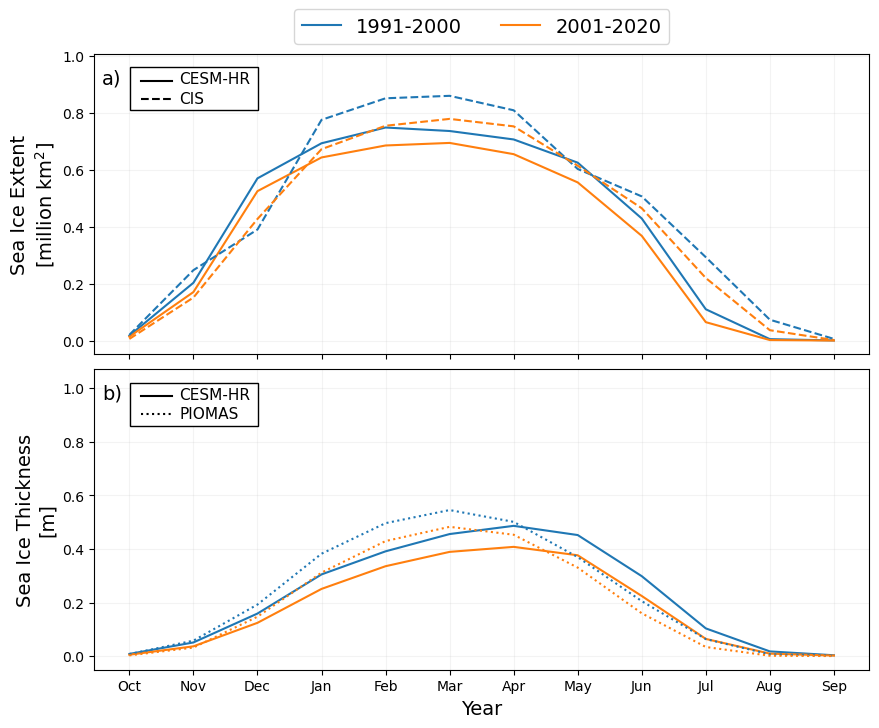

In [70]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

model_cis_dt = [model_1991_00_monthly, model_2001_20_monthly, cis_1991_00_monthly, cis_2001_20_monthly]
hi_dt = [model_hi_1991_00_monthly, model_hi_2001_20_monthly, piomas_hi_1991_00_monthly, piomas_hi_2001_20_monthly]

cl = ['tab:blue', 'tab:orange', 'tab:blue', 'tab:orange']
month_dt = ['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']
lb = ['1991-2000', '2001-2020']

# First plot
for i in range(len(model_cis_dt)):
    if i < 2:
        ls = '-'
        ax[0].plot(month_dt, np.append(model_cis_dt[i][9:], model_cis_dt[i][:9]), linestyle=ls, color=cl[i])
    if i >= 2:
        ls = '--'
        ax[0].plot(month_dt, np.append(model_cis_dt[i][9:], model_cis_dt[i][:9]), linestyle=ls, color=cl[i])

ax[0].set_ylabel('Sea Ice Extent\n[million km$^2$]', fontsize=14)
ax[0].grid(alpha=0.15)

# Adding lines and labels at the top of the first plot
for i in range(2):
    ax[0].plot([], [], color=cl[i], linestyle='-', label=lb[i])
    
ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.18), ncol=2, fontsize=14)

# Second plot
for i in range(len(hi_dt)):
    if i < 2:
        ls = '-'
        ax[1].plot(month_dt, np.append(hi_dt[i][9:], hi_dt[i][:9]), linestyle=ls, color=cl[i])
    if i >= 2:
        ls = ':'
        ax[1].plot(month_dt, np.append(hi_dt[i][9:], hi_dt[i][:9]), linestyle=ls, color=cl[i])

ax[1].set_ylabel('Sea Ice Thickness\n[m]', fontsize=14)
ax[1].set_xlabel('Year', fontsize=14)
ax[1].grid(alpha=0.15)

# Add rectangles
rectangle = patches.Rectangle((0.005, 0.81), 2, 0.15, edgecolor='black', facecolor='white', linewidth=1, zorder=10)
ax[0].add_patch(rectangle)
#rectangle2 = patches.Rectangle((0.005, 0.46), 2, 0.09, edgecolor='black', facecolor='white', linewidth=1, zorder=10)
#ax[1].add_patch(rectangle2)
rectangle2 = patches.Rectangle((0.005, 0.86), 2, 0.16, edgecolor='black', facecolor='white', linewidth=1, zorder=10)
ax[1].add_patch(rectangle2)


# Add CESM-HR text and line
ax[0].text(0.11, 0.9, 'CESM-HR', transform=ax[0].transAxes, fontsize=11, zorder=11)
ax[0].plot([0.06, 0.1], [0.91, 0.91], color='black', transform=ax[0].transAxes, linestyle='-', zorder=11)

# Add CIS text and dashed line
ax[0].text(0.11, 0.835, 'CIS', transform=ax[0].transAxes, fontsize=11, zorder=11)
ax[0].plot([0.06, 0.1], [0.85, 0.85], color='black', transform=ax[0].transAxes, linestyle='--', zorder=11)

# Add CESM-HR text and line
ax[1].text(0.11, 0.9, 'CESM-HR', transform=ax[1].transAxes, fontsize=11, zorder=11)
ax[1].plot([0.06, 0.1], [0.91, 0.91], color='black', transform=ax[1].transAxes, linestyle='-', zorder=11)

# Add PIOMAS text and dashed line
ax[1].text(0.11, 0.835, 'PIOMAS', transform=ax[1].transAxes, fontsize=11, zorder=11)
ax[1].plot([0.06, 0.1], [0.85, 0.85], color='black', transform=ax[1].transAxes, linestyle=':', zorder=11)

ax[0].text(0.01, 0.9, 'a)', transform=ax[0].transAxes,  fontsize=14)
ax[1].text(0.01, 0.9, 'b)', transform=ax[1].transAxes,  fontsize=14)

plt.subplots_adjust(hspace=0.05)
plt.savefig('/storage2/tkyeimiah/Plots/new-Fig4a-.jpg', dpi=500, bbox_inches='tight')
plt.show()


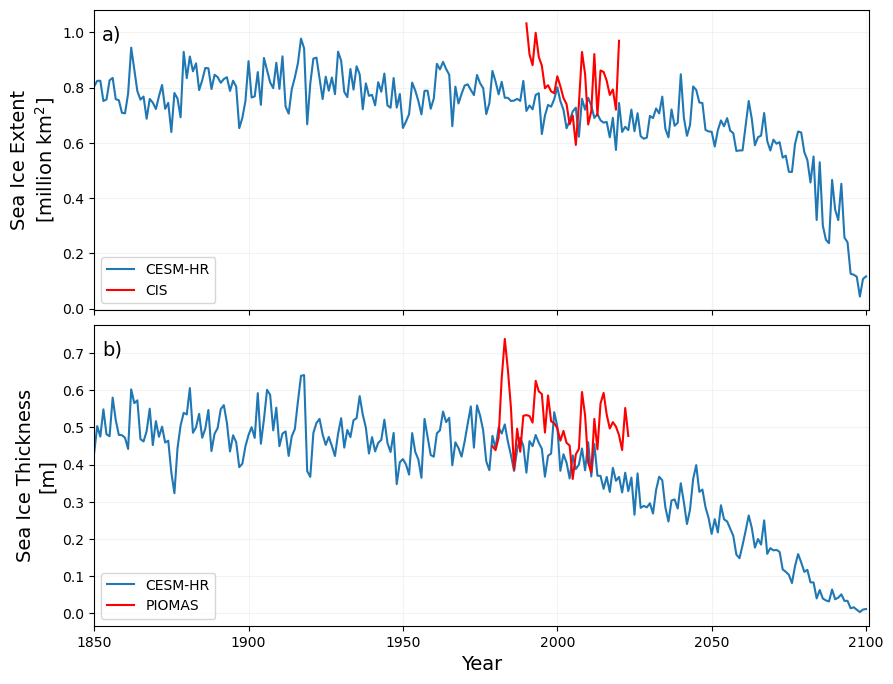

In [71]:
# SIE  : CESM-HR
march_aice_hist = aice_hist_region.sel(time=slice('1850','2005'))[2::12].sum(('nj', 'ni'))
march_aice_proj = aice_proj_region.sel(time=slice('2006','2100'))[2::12].sum(('nj', 'ni'))
march_aice=xr.concat([march_aice_hist,march_aice_proj], dim='time')

# SIE : CIS
obs_SIE=obs_CT_region.sel(time=slice('1990','2020'))
obs_SIE_march=obs_SIE[2::12].sum(['rlat','rlon'])

# SIT : CESM-HR
march_hi_hist = hi_hist_region1.sel(time=slice('1850','2005'))[2::12].mean(('nj', 'ni'))
march_hi_proj = hi_proj_region1.sel(time=slice('2006','2100'))[2::12].mean(('nj', 'ni'))
march_hi=xr.concat([march_hi_hist,march_hi_proj], dim='time')

# SIT : PIOMAS
march_piomas_hi = piomas_hi[2::12].mean(('y', 'x'))


fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
years =np.arange(1850,2101,1)
#yearss =np.arange(1850,2101)
#ax[2]=ax[1].twinx()
# First plot              
ax[0].plot(years, march_aice, label='CESM-HR')
ax[0].plot(np.arange(1990,2021), obs_SIE_march, color='red', label='CIS')
ax[0].set_ylabel('Sea Ice Extent\n[million km$^2$]', fontsize=14)
ax[0].grid(alpha=0.15)     
ax[0].legend(loc='lower left')
ax[0].set_xlim(1850, 2101)
# Second plot         
ax[1].plot(years, march_hi, label='CESM-HR')
ax[1].plot(np.arange(1979,2024), march_piomas_hi, color='red', label='PIOMAS')
#ax[2].plot(ice_season_days_df['Year'],ice_season_days_df['Days Above 0.3m'])
ax[1].set_ylabel('Sea Ice Thickness\n[m]', fontsize=14)
ax[1].grid(alpha=0.15)
ax[1].legend(loc='lower left') 
#
ax[1].set_xlabel('Year', fontsize=14)

ax[0].text(0.01, 0.9, 'a)',transform=ax[0].transAxes,  fontsize=14)
ax[1].text(0.01, 0.9, 'b)',transform=ax[1].transAxes,  fontsize=14)

plt.subplots_adjust(hspace=0.05)
plt.savefig('/storage2/tkyeimiah/Plots/new-Fig2.jpg', dpi=500, bbox_inches='tight')
plt.show()

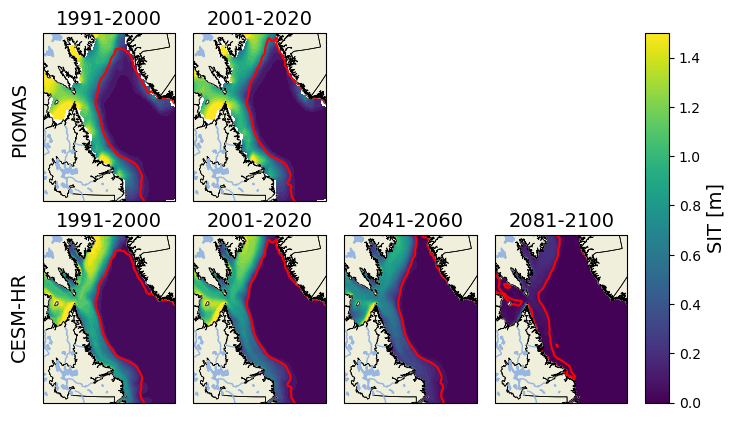

In [72]:
#=========sic_region==max========================

fig = plt.figure(figsize=(8,4.8))

sic_data = [model_sic_1991_00_, model_sic_2001_20_,
            model_sic_1991_00_, model_sic_2001_20_, model_sic_2041_60_, model_sic_2081_100_]

hi_data1 = [piomas_hi_1991_00, piomas_hi_2001_20,
            model_hi_1991_00b, model_hi_2001_20b, model_hi_2041_60b, model_hi_2081_100b]
titles = ['1991-2000', '2001-2020', '1991-2000', '2001-2020', '2041-2060', '2081-2100' ]

global_min = np.min([np.nanmin(data.max('time').values) for data in hi_data1])
#global_max = np.max([np.nanmax(data.max('time').values) for data in hi_data1])
norm = plt.Normalize(vmin=global_min, vmax=1.5)
norm2= plt.Normalize(vmin=global_min, vmax=1.7)
norm1= plt.Normalize(vmin=global_min, vmax=1.2)
cb=cm.ScalarMappable(norm=norm)


x0, x1, y0, y1 =-68,-48,51,67

# Calculate the central longitude and latitude
c_lon = (x0 + x1) / 2
c_lat = (y0 + y1) / 2
subplot_positions = [1, 2, 5, 6, 7, 8]
for i, v in enumerate(hi_data1):
#for i in range(3):
    # Create a subplot with the PlateCarree projection
    ax = plt.subplot(2,4, subplot_positions[i],projection=ccrs.AlbersEqualArea(central_longitude=c_lon, 
                                                              central_latitude=c_lat,standard_parallels=(y0, y1)))
    ax.set_title(titles[i], fontsize=14)
    ax.coastlines(zorder=2)
    ax.add_feature(cfeature.LAND, zorder=2)
    ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5,  zorder=2)
    ax.add_feature(cfeature.LAKES.with_scale('10m'),  zorder=2)
    ax.add_feature(cfeature.RIVERS.with_scale('10m'),  zorder=2)
    ax.set_extent([x0, x1, y0, y1])
    #ax.text(0,1.05,letter[i], transform=ax.transAxes, fontsize=9)
    
    if i in [0,1]:
        contf=ax.contourf(piomas_data_region.lon_scaler, piomas_data_region.lat_scaler, hi_data1[i][3::12].mean('time'),
                          norm=norm1, levels=45, transform=ccrs.PlateCarree(), zorder=1)
        ax.contour(sic_data[i].TLON, sic_data[i].TLAT, sic_data[i],levels=[15],norm=norm,colors='red',linewidth=5,
               transform=ccrs.PlateCarree(), zorder=1)
        
    if i in [2,3,4,5]:
        contf=ax.contourf(hi_data1[i].TLON, hi_data1[i].TLAT, hi_data1[i][3::12].mean('time'),levels=45,
                          norm=norm2, transform=ccrs.PlateCarree(), zorder=1)
        ax.contour(sic_data[i].TLON, sic_data[i].TLAT, sic_data[i],levels=[15],norm=norm,colors='red',linewidth=5,
               transform=ccrs.PlateCarree(), zorder=1)
   
    
    
cbar_ax = fig.add_axes([0.9, 0.11, 0.03, 0.77])
cbar=fig.colorbar(cb, cax=cbar_ax, ax=ax, orientation='vertical',label='SIC [%]')
cbar.ax.tick_params(labelsize=10)
cbar.ax.set_ylabel('SIT [m]', fontsize=14)  

name=['PIOMAS','CESM-HR']
x=[0.13,0.13]
y=[0.7,0.29]
for i in range (2):
    fig.text(x[i],y[i], name[i], va='bottom', ha='center', rotation='vertical',
             rotation_mode='anchor',fontsize=14)
plt.subplots_adjust(wspace=-0.1)
#plt.subplots_adjust(hspace=0.7)
plt.savefig('/storage2/tkyeimiah/Plots/new-Fig6.jpg',dpi=500, bbox_inches='tight')
plt.show()



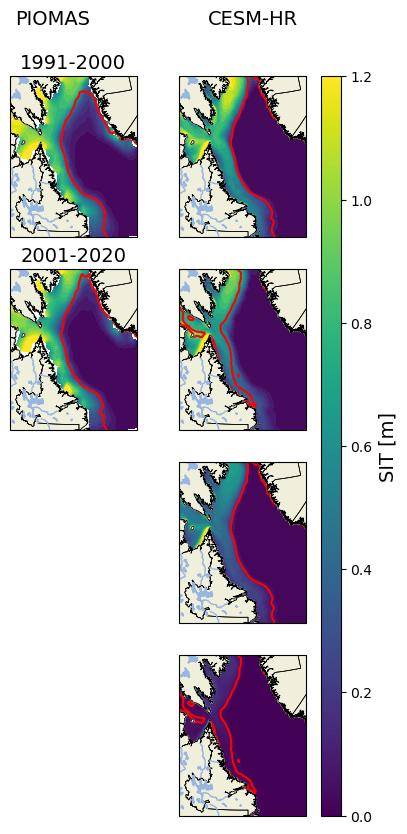

In [73]:
#=========sic_region==max========================

fig = plt.figure(figsize=(4,9.6))

sic_data = [model_sic_1991_00_, model_sic_2001_20_, model_sic_2041_60_, model_sic_2081_100_]

hi_data1 = [piomas_hi_1991_00, piomas_hi_2001_20, model_hi_1991_00b, model_hi_2001_20b, model_hi_2041_60b, model_hi_2081_100b]

titles = ['1991-2000', '2001-2020', '2041-2060', '2081-2100']

# Min and normalization
global_min = np.min([np.nanmin(data.max('time').values) for data in hi_data1])
norm1 = plt.Normalize(vmin=global_min, vmax=1.2)
norm2 = plt.Normalize(vmin=global_min, vmax=1.7)

cb = cm.ScalarMappable(norm=norm1)

# Coordinates and extent
x0, x1, y0, y1 = -68, -48, 51, 67
c_lon = (x0 + x1) / 2
c_lat = (y0 + y1) / 2

# Subplot structure
subplot_positions = [(i, j) for i in range(4) for j in range(2)]
data_pairs = [
    (hi_data1[0], sic_data[0], norm1, piomas_data_region.lon_scaler, piomas_data_region.lat_scaler),
    (hi_data1[2], sic_data[2], norm2, hi_data1[2].TLON, hi_data1[2].TLAT),
    (hi_data1[1], sic_data[1], norm1, piomas_data_region.lon_scaler, piomas_data_region.lat_scaler),
    (hi_data1[3], sic_data[3], norm2, hi_data1[3].TLON, hi_data1[3].TLAT),
    (None, None, None, None, None),  # Placeholder for the empty slot in PIOMAS 2041-2060
    (hi_data1[4], sic_data[2], norm2, hi_data1[4].TLON, hi_data1[4].TLAT),
    (None, None, None, None, None),  # Placeholder for the empty slot in PIOMAS 2081-2100
    (hi_data1[5], sic_data[3], norm2, hi_data1[5].TLON, hi_data1[5].TLAT)
]

for pos, (hi_data, sic_data, norm, lon, lat) in zip(subplot_positions, data_pairs):
    if hi_data is None:
        continue  # Skip placeholder subplots
    
    ax = plt.subplot2grid((4, 2), pos, rowspan=1, colspan=1, projection=ccrs.AlbersEqualArea(central_longitude=c_lon, 
                                                                                             central_latitude=c_lat,
                                                                                             standard_parallels=(y0, y1)))
    if pos[1] == 0:  # Titles for the first column
        index = pos[0] if pos[0] < 2 else pos[0] - 2
        ax.set_title(titles[index], fontsize=14)

    ax.coastlines(zorder=2)
    ax.add_feature(cfeature.LAND, zorder=2)
    ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5, zorder=2)
    ax.add_feature(cfeature.LAKES.with_scale('10m'), zorder=2)
    ax.add_feature(cfeature.RIVERS.with_scale('10m'), zorder=2)
    ax.set_extent([x0, x1, y0, y1])

    contf = ax.contourf(lon, lat, hi_data[2::12].mean('time'), levels=45,
                        norm=norm, transform=ccrs.PlateCarree(), zorder=1)
    ax.contour(sic_data.TLON, sic_data.TLAT, sic_data, levels=[15], norm=norm, colors='red', linewidth=1,
               transform=ccrs.PlateCarree(), zorder=1)

# Color bar
cbar_ax = fig.add_axes([0.92, 0.11, 0.05, 0.77])
cbar = fig.colorbar(cb, cax=cbar_ax, ax=ax, orientation='vertical', label='SIC [%]')
cbar.ax.tick_params(labelsize=10)
cbar.ax.set_ylabel('SIT [m]', fontsize=14)

# Add labels
name = ['PIOMAS', 'CESM-HR']
x = [0.25, 0.75]
y = [0.93, 0.69, 0.45, 0.21]
for i in range(2):
    fig.text(x[i], y[0], name[i],  va='bottom', ha='center', rotation='horizontal', fontsize=14)

#plt.subplots_adjust(wspace=0.4, hspace=0.4)
#plt.savefig('/storage2/tkyeimiah/Plots/new-Fig6.jpg', dpi=500, bbox_inches='tight')
plt.show()


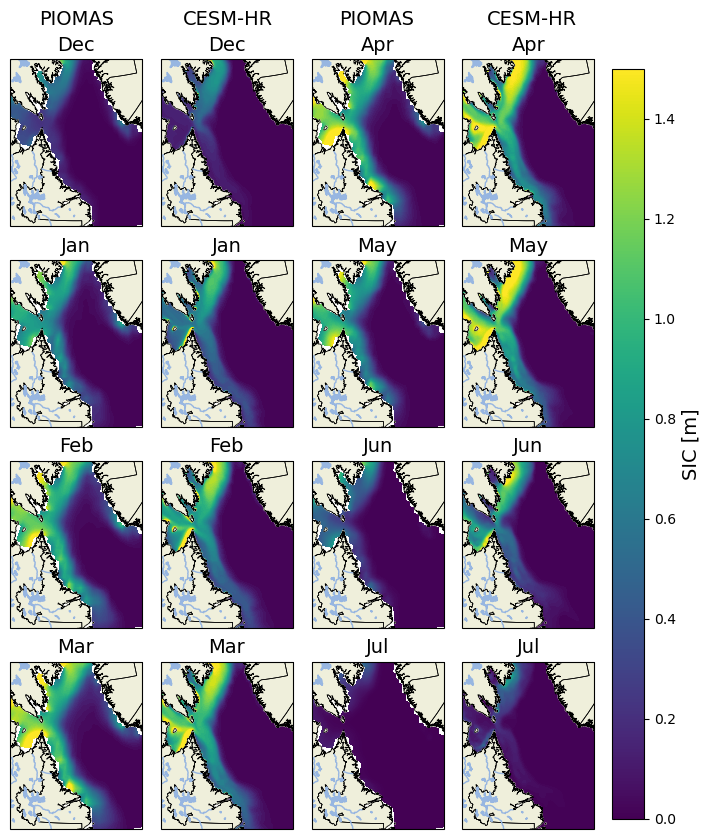

In [74]:
fig = plt.figure(figsize=(8,10))
piomas_data1=[piomas_hi_months[-1],piomas_hi_months[3],piomas_hi_months[0],piomas_hi_months[4],
          piomas_hi_months[1],piomas_hi_months[5],piomas_hi_months[2],piomas_hi_months[6]]

model_data=[hi_months[-1], hi_months[3], hi_months[0], hi_months[4], hi_months[1], hi_months[5],
            hi_months[2], hi_months[6]]

titles = ['Dec','Apr','Jan','May','Feb','Jun','Mar','Jul',]
#name=['a)','c)','e)','g)','i)','k)','m)','o)','q)']
#name1=['b)','d)','f)','h)','j)','l)','n)','p)','r)']

norm = plt.Normalize(vmin=0, vmax=1.5)
norm2= plt.Normalize(vmin=0, vmax=1.7)
norm1= plt.Normalize(vmin=0, vmax=1.2)
cb=cm.ScalarMappable(norm=norm)

x0, x1, y0, y1 =-68,-48,51,67

# Calculate the central longitude and latitude
c_lon = (x0 + x1) / 2
c_lat = (y0 + y1) / 2
for i in range(16):
    index = i // 2 
    
    if i % 2 == 0:
        ax = plt.subplot(4, 4, i+1, projection=ccrs.AlbersEqualArea(central_longitude=c_lon,
                                                                     central_latitude=c_lat,
                                                                     standard_parallels=(y0, y1)))
        ax.set_title(titles[index], fontsize=14)
        ax.add_feature(cfeature.LAND, zorder=2)
        ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5, zorder=2)
        ax.add_feature(cfeature.LAKES.with_scale('10m'), zorder=2)
        ax.add_feature(cfeature.RIVERS.with_scale('10m'), zorder=2)
        ax.set_extent([x0, x1, y0, y1])
        ax.contourf(piomas_data_region.lon_scaler, piomas_data_region.lat_scaler, piomas_data1[index],levels=100, norm=norm1,
                    transform=ccrs.PlateCarree())
        
    else:
        ax = plt.subplot(4, 4, i+1, projection=ccrs.AlbersEqualArea(central_longitude=c_lon,
                                                                     central_latitude=c_lat,
                                                                     standard_parallels=(y0, y1)))
        if index < len(model_data):
            ax.set_title(titles[index], fontsize=14)
            ax.add_feature(cfeature.LAND, zorder=2)
            ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5, zorder=2)
            ax.add_feature(cfeature.LAKES.with_scale('10m'), zorder=2)
            ax.add_feature(cfeature.RIVERS.with_scale('10m'), zorder=2)
            ax.set_extent([x0, x1, y0, y1])
            ax.contourf(model_data[index].TLON, model_data[index].TLAT, model_data[index],levels=100, norm=norm,
                        transform=ccrs.PlateCarree(), zorder=1)

cbar_ax = fig.add_axes([0.9, 0.12, 0.04, 0.75])
cbar=fig.colorbar(cb, cax=cbar_ax, ax=ax, orientation='vertical',label='SIC [%]')
cbar.ax.tick_params(labelsize=10)
cbar.ax.set_ylabel('SIC [m]', fontsize=14)

name=['PIOMAS', 'CESM-HR', 'PIOMAS', 'CESM-HR']
x=[0.23, 0.42, 0.605, 0.8]
y=[0.91,0.91,0.91,0.91]
for i in range (4):
    fig.text(x[i],y[i], name[i], va='bottom', ha='center', rotation='horizontal',
             rotation_mode='anchor',fontsize=14)


plt.subplots_adjust(wspace=-0.1)
plt.savefig('/storage2/tkyeimiah/Plots/new-Fig7.jpg',dpi=500, bbox_inches='tight')
plt.show()

### LANDFAST

In [75]:
path = '/storage2/tkyeimiah'


uvel_dh = xr.open_dataset(path+'/iHESP/EM1/hist/uvel_hist/uvel_hist.nc')
uvel_dp = xr.open_dataset(path+'/iHESP/EM1/proj/uvel_proj/uvel_proj.nc')


vvel_dh = xr.open_dataset(path+'/iHESP/EM1/hist/vvel_hist/vvel_hist.nc')
vvel_dp = xr.open_dataset(path+'/iHESP/EM1/proj/vvel_proj/vvel_proj.nc')

In [76]:
uvel_hist=shift_month(uvel_dh['uvel'])
uvel_proj=shift_month(uvel_dp['uvel'])

vvel_hist=shift_month(vvel_dh['vvel'])
vvel_proj=shift_month(vvel_dp['vvel'])

In [77]:
# Define the Labrador coast boundaries (replace these with your desired region)
lon_min, lon_max =287, 315 #73W & 45W
lat_min, lat_max =51,69


# Create a mask for Labrador coast 
mask_uvel_hist = ((uvel_hist.TLAT >= lat_min) & (uvel_hist.TLAT <= lat_max) &
        (uvel_hist.TLON >= lon_min) & (uvel_hist.TLON <= lon_max))

mask_uvel_proj = ((uvel_proj.TLAT >= lat_min) & (uvel_proj.TLAT <= lat_max) &
        (uvel_proj.TLON >= lon_min) & (uvel_proj.TLON <= lon_max))

mask_vvel_hist = ((vvel_hist.TLAT >= lat_min) & (vvel_hist.TLAT <= lat_max) &
        (vvel_hist.TLON >= lon_min) & (vvel_hist.TLON <= lon_max))

mask_vvel_proj = ((vvel_proj.TLAT >= lat_min) & (vvel_proj.TLAT <= lat_max) & 
        (vvel_proj.TLON >= lon_min) & (vvel_proj.TLON <= lon_max))

# Apply the mask to the aice variable
uvel_hist_region_ =uvel_hist.where(mask_uvel_hist, drop=True)
uvel_proj_region_ =uvel_proj.where(mask_uvel_proj, drop=True)
vvel_hist_region_ =vvel_hist.where(mask_vvel_hist, drop=True)
vvel_proj_region_ =vvel_proj.where(mask_vvel_proj, drop=True)

In [78]:
vvel_proj_region_ 

<xarray.DataArray 'vvel' (time: 1154, nj: 345, ni: 227)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * time     (time) object 2006-01-01 00:00:00 ... 2102-02-01 00:00:00
    TLON     (nj, ni) float32 1e+30 1e+30 1e+30 1e+30 ... 305.7 305.9 306.0
    TLAT     (nj, ni) float32 1e+30 1e+30 1e+30 1e+30 ... 71.88 71.9 71.92 71.94
Dimensions without coordinates: nj, ni
Attributes:
    long_name:     ice velocity (y)
    units:         cm/s
    comment:       positive is y direction on U grid
    cell_methods:  time: mean
    time_rep:      averaged

In [79]:
# Function for landfast ice
def landfast_ice(uvel,vvel,conc,threshold):
    # Calculate the magnitude of the velocity
    velocity_magnitude = np.sqrt(uvel**2 + vvel**2)

    # Define a threshold for landfast ice 
    velocity_threshold = threshold  # 5*10^-4m/s == 0.05cm/s /// 4cm/s

    # Define a threshold for sea ice concentration to ensure ice presence
    concentration_threshold = 90 # 90%

    # Create a mask for where the velocity magnitude is less than the threshold
    landfast_mask = (velocity_magnitude <= velocity_threshold) &  (conc >= concentration_threshold)
    
    # Apply the mask to the sea ice concentration
    landfast_ice_concentration = conc.where(landfast_mask)
    
    return landfast_ice_concentration

In [80]:
#0.5cm
model_fastIce_hist_05_=landfast_ice(uvel_hist_region_, vvel_hist_region_, aice_hist_region_, 0.1).sel(time=slice('1850','2005'))
model_fastIce_proj_05_=landfast_ice(uvel_proj_region_, vvel_proj_region_, aice_proj_region_, 0.1).sel(time=slice('2006','2100'))
model_fastIce = xr.concat([model_fastIce_hist_05_, model_fastIce_proj_05_], dim='time')

####################
model_fastIce_hist_05 = (model_fastIce_hist_05_ * tarea_hist_region_)
model_fastIce_proj_05 = (model_fastIce_proj_05_ * tarea_proj_region_)
model_fastIce_05 = xr.concat([model_fastIce_hist_05, model_fastIce_proj_05], dim='time')

In [81]:
lon_min, lon_max =296, 299 #73W & 45W
lat_min, lat_max =58,58.5
#sat:298.4,298.5 #tak:298.5,298.6
#sat:56.46,56.46 #tak:56.41,56.42

# Create a mask for Labrador coast 
mask_u = ((model_fastIce.TLAT >= lat_min) & (model_fastIce.TLAT <= lat_max) &
        (model_fastIce.TLON >= lon_min) & (model_fastIce.TLON <= lon_max))
model_fastIcee=model_fastIce.where(mask_u, drop=True)
#model_fastIce[0].plot()

In [82]:
# Create a mask for Labrador coast 
mask_pu = ((piomas_data.lat_scaler >= lat_min) & (piomas_data.lat_scaler<= lat_max) &
              (piomas_data.lon_scaler >= lon_min) & (piomas_data.lon_scaler <= lon_max))
piomas_data_=piomas_data.where(mask_pu, drop=True)
piomas_data_region1 = piomas_data_.where(piomas_data_ < 9999.9)

In [83]:
model_fastIcee

<xarray.DataArray 'aice' (time: 3012, nj: 14, ni: 23)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * time     (time) object 1850-01-01 00:00:00 ... 2100-12-01 00:00:00
    TLON     (nj, ni) float32 296.9 297.0 297.1 297.2 ... 298.5 298.6 298.7
    TLAT     (nj, ni) float32 57.73 57.75 57.77 57.78 ... 58.79 58.81 58.83
Dimensions without coordinates: nj, ni
Attributes:
    long_name:     ice area  (aggregate)
    units:         %
    comment:       none
    cell_methods:  time: mean
    time_rep:      averaged

In [84]:
np.nanmax(model_fastIcee.values)

99.907845

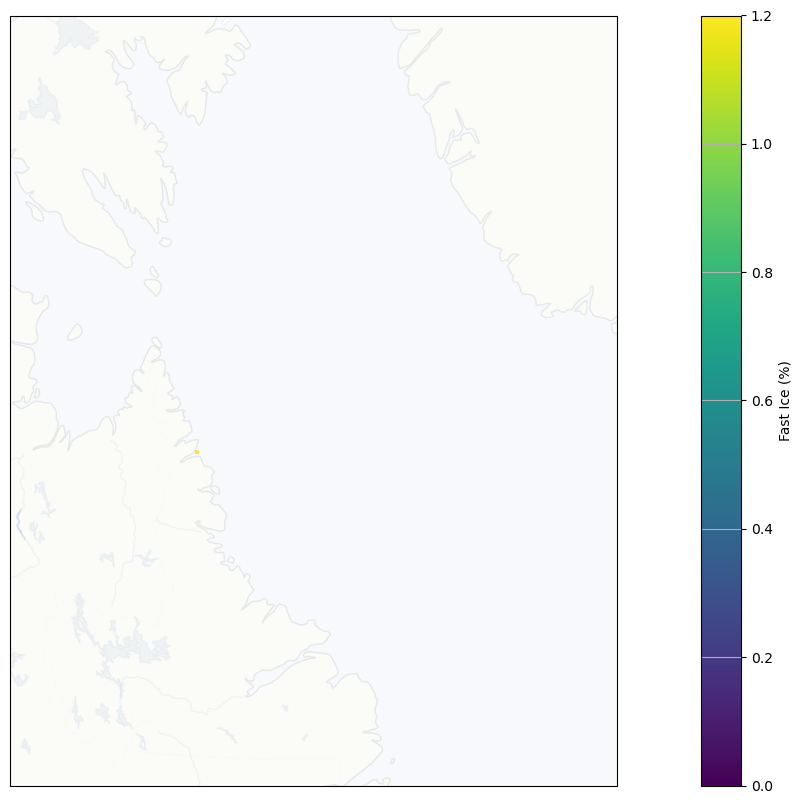

In [85]:
fig = plt.figure(figsize=(10,10))

#selected_data=[new_hi_hist_region]

titles=title=['HR-CESM \n0.1 cms$^{-1}$']
norm = plt.Normalize(0, 1.2)
cb=cm.ScalarMappable(norm=norm)


x0, x1, y0, y1 =-68,-48,51,67

# Calculate the central longitude and latitude
c_lon = (x0 + x1) / 2
c_lat = (y0 + y1) / 2
ax = plt.subplot(1,1, 1,projection=ccrs.AlbersEqualArea(central_longitude=c_lon, 
                                                              central_latitude=c_lat,standard_parallels=(y0, y1)))
ax.coastlines(alpha=0.03, zorder=11)
ax.add_feature(cfeature.LAND, alpha=0.2)
ax.add_feature(cfeature.OCEAN, alpha=0.075)
ax.add_feature(cfeature.STATES, alpha=0.003)
ax.add_feature(cfeature.LAKES.with_scale('10m'),  alpha=0.1, zorder=2)
ax.add_feature(cfeature.RIVERS.with_scale('10m'),  alpha=0.1, zorder=2)
ax.set_extent([x0, x1, y0, y1])
ax.pcolormesh(model_fastIcee[0].TLON, model_fastIcee[0].TLAT, model_fastIcee[0],
                    norm=norm, transform=ccrs.PlateCarree(), zorder=1)


cbar_ax = fig.add_axes([0.9, 0.11, 0.04, 0.77])
cbar=fig.colorbar(cb, cax=cbar_ax, ax=ax, orientation='vertical',label='Fast Ice (%)')
cbar.ax.tick_params(labelsize=10)
plt.grid()

plt.savefig('/storage2/tkyeimiah/Plots/Fig13.jpg',dpi=500, bbox_inches='tight')
plt.show()

In [86]:
new_hi_hist_region=hi_hist_region1.sel(time=slice('1850','2005')).where(mask_u, drop=True)
new_hi_proj_region=hi_proj_region1.sel(time=slice('2006','2100')).where(mask_u, drop=True)
all_hist=xr.concat([new_hi_hist_region,new_hi_proj_region], dim='time')

###
piomas_hi_all=piomas_data_region1.heff

In [87]:
new_hi_proj_region

<xarray.DataArray 'hi' (time: 1140, nj: 14, ni: 23)>
array([[[       nan,        nan,        nan, ..., 0.5846239 ,
                nan,        nan],
        [       nan,        nan,        nan, ..., 0.58112836,
                nan,        nan],
        [       nan,        nan,        nan, ..., 0.57582563,
         0.6024082 ,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ..., 0.3581992 ,
                nan,        nan],
        [       nan,        nan,        nan, ..., 0.36189786,
                nan,        nan],
        [       nan,        nan,        nan, ..., 0.36512017,
         0.38622618,        nan],
...
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ..., 0.        ,
                nan,        nan],
        [       nan,        nan,        nan, ..., 0.        ,
                nan,        nan],
        [       nan,        nan,        nan, ..., 0.        ,
         0.        ,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]], dtype=float32)
Coordinates:
  * time     (time) object 2006-01-01 00:00:00 ... 2100-12-01 00:00:00
    TLON     (nj, ni) float32 296.9 297.0 297.1 297.2 ... 298.5 298.6 298.7
    TLAT     (nj, ni) float32 57.73 57.75 57.77 57.78 ... 58.79 58.81 58.83
Dimensions without coordinates: nj, ni
Attributes:
    long_name:     grid cell mean ice thickness
    units:         m
    comment:       ice volume per unit grid cell area
    cell_methods:  time: mean
    time_rep:      averaged

In [88]:
# Function to calculate the number of days above 0.3 meters in each month
def days_above_threshold(monthly_mean, threshold=0.3, days_in_month=30):
    days_above = 0
    for i in range(1, len(monthly_mean)):
        if monthly_mean[i-1] < threshold and monthly_mean[i] > threshold:
            days_above += (threshold - monthly_mean[i-1]) / (monthly_mean[i] - monthly_mean[i-1]) * days_in_month
        elif monthly_mean[i-1] > threshold and monthly_mean[i] < threshold:
            days_above += (monthly_mean[i-1] - threshold) / (monthly_mean[i-1] - monthly_mean[i]) * days_in_month
        elif monthly_mean[i-1] > threshold and monthly_mean[i] > threshold:
            days_above += days_in_month
    return days_above

# Calculate the total number of days above 0.3 meters for each year
ice_season_days = {}

for year in range(1850, 2101):
    yearly_data = all_hist.sel(time=str(year))
    monthly_mean = yearly_data.groupby('time.month').mean('time').mean(('nj', 'ni')).values
    days_above = days_above_threshold(monthly_mean)
    ice_season_days[year] = days_above

# Convert the result to a DataFrame and display
ice_season_days_df = pd.DataFrame(list(ice_season_days.items()), columns=['Year', 'Days'])

In [89]:
# Function to interpolate the day when thickness crosses 0.3 meters
def interpolate_day(thickness_before, thickness_after, threshold=0.3, days_in_month=30):
    if (thickness_before < threshold and thickness_after > threshold) or (thickness_before > threshold and thickness_after < threshold):
        f = interp1d([thickness_before, thickness_after], [0, days_in_month])
        return f(threshold)
    return None

# Calculate the total number of days above 0.3 meters for each year
def calculate_days_above_threshold(data, threshold=0.3):
    ice_season_days = {}

    for year in range(1850, 2101):
        yearly_data = data.sel(time=str(year))
        monthly_mean = yearly_data.groupby('time.month').mean('time').mean(('nj', 'ni')).values
        
        days_above = 0
        for i in range(len(monthly_mean) - 1):
            current_month_mean = monthly_mean[i]
            next_month_mean = monthly_mean[i + 1]
            
            if current_month_mean > threshold:
                days_above += 30  # Whole month is above threshold
            elif current_month_mean < threshold and next_month_mean > threshold:
                start_day = interpolate_day(current_month_mean, next_month_mean, threshold)
                if start_day is not None:
                    days_above += (30 - start_day)
            elif current_month_mean > threshold and next_month_mean < threshold:
                end_day = interpolate_day(current_month_mean, next_month_mean, threshold)
                if end_day is not None:
                    days_above += end_day
        
        # Handle December to January interpolation
        if monthly_mean[-1] > threshold:
            days_above += 30  # December is above threshold
        elif monthly_mean[-1] < threshold and monthly_mean[0] > threshold:
            start_day = interpolate_day(monthly_mean[-1], monthly_mean[0], threshold)
            if start_day is not None:
                days_above += (30 - start_day)
        
        ice_season_days[year] = days_above

    return ice_season_days


ice_season_days = calculate_days_above_threshold(all_hist)

# Convert the result to a DataFrame and display
ice_season_days_dff = pd.DataFrame(list(ice_season_days.items()), columns=['Year', 'Days'])

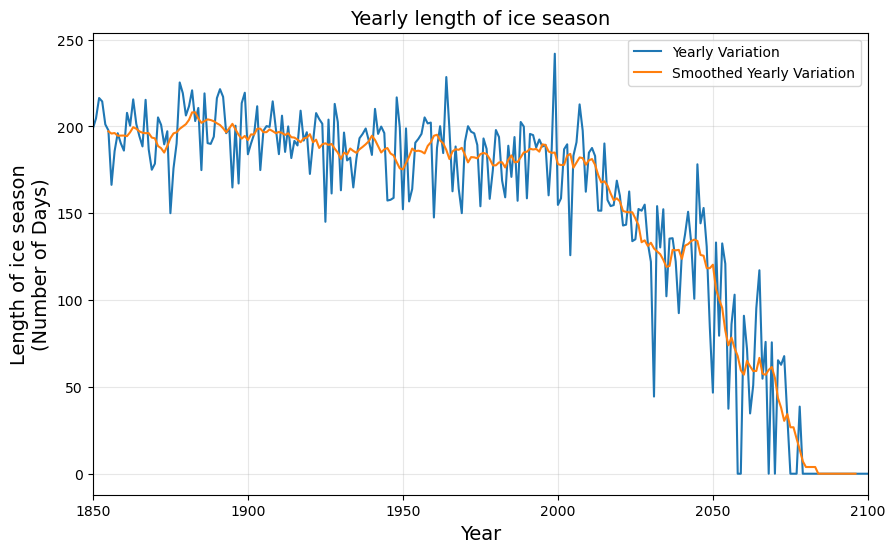

In [90]:
fig, ax=plt.subplots(figsize=(10,6))

# Calculate the mean across all years
#overall_mean = yearly_mean.mean('year')
# Create an array with the same size as the number of years with the overall mean value
#mean_line = np.full_like(yearly_mean, overall_mean)
# Plot the yearly variations and the mean line
ax.plot(ice_season_days_dff['Year'], ice_season_days_dff['Days'], label='Yearly Variation')
ax.plot(ice_season_days_dff['Year'], ice_season_days_dff['Days'].rolling(window=10, center=True).mean(), label='Smoothed Yearly Variation')

ax.set_title('Yearly length of ice season',  fontsize=14)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Length of ice season\n(Number of Days)', fontsize=14)
plt.grid(alpha=0.3)
plt.xlim(1850,2100)
plt.legend()
plt.savefig('/storage2/tkyeimiah/Plots/Iceseason_Length.jpg',dpi=500, bbox_inches='tight')
plt.show()

In [91]:
def interpolate_day(thickness_before, thickness_after, threshold=0.3, days_in_month=30):
    if (thickness_before < threshold and thickness_after > threshold) or (thickness_before > threshold and thickness_after < threshold):
        f = interp1d([thickness_before, thickness_after], [0, days_in_month])
        return f(threshold)
    return None

def calculate_days_above_threshold(data, threshold=0.3):
    ice_season_days = {}

    for year in range(1850, 2101):
        yearly_data = data.sel(time=str(year))
        monthly_mean = yearly_data.groupby('time.month').mean('time').mean(('nj', 'ni')).values
        
        
        days_above = 0
        for i in range(len(monthly_mean) - 1):
            current_month_mean = monthly_mean[i]
            next_month_mean = monthly_mean[i + 1]
            
            if current_month_mean > threshold and next_month_mean > threshold:
                days_above += 30  # Whole month is above threshold
            elif current_month_mean < threshold and next_month_mean > threshold:
                start_day = interpolate_day(current_month_mean, next_month_mean, threshold)
                if start_day is not None:
                    days_above += (30 - start_day)
            elif current_month_mean > threshold and next_month_mean < threshold:
                end_day = interpolate_day(current_month_mean, next_month_mean, threshold)
                if end_day is not None:
                    days_above += end_day
        
        # Handle December to January interpolation
        if monthly_mean[-1] > threshold and monthly_mean[0] > threshold:
            days_above += 30  # Both December and January are above threshold
        elif monthly_mean[-1] < threshold and monthly_mean[0] > threshold:
            start_day = interpolate_day(monthly_mean[-1], monthly_mean[0], threshold)
            if start_day is not None:
                days_above += (30 - start_day)
        elif monthly_mean[-1] > threshold and monthly_mean[0] < threshold:
            end_day = interpolate_day(monthly_mean[-1], monthly_mean[0], threshold)
            if end_day is not None:
                days_above += end_day
        
        ice_season_days[year] = days_above

    return ice_season_days

# Assuming `all_hist` is your dataset
ice_season_days = calculate_days_above_threshold(all_hist)

# Convert the result to a DataFrame and display
ice_season_days_df = pd.DataFrame(list(ice_season_days.items()), columns=['Year', 'Days'])

In [92]:
piomas_hi_all

<xarray.DataArray 'heff' (time: 540, y: 2, x: 3)>
array([[[       nan,        nan, 0.5310831 ],
        [       nan,        nan, 0.51855093]],

       [[       nan,        nan, 0.916346  ],
        [       nan,        nan, 0.76839393]],

       [[       nan,        nan, 0.5266019 ],
        [       nan,        nan, 0.5318775 ]],

       ...,

       [[       nan,        nan, 0.        ],
        [       nan,        nan, 0.        ]],

       [[       nan,        nan, 0.00545041],
        [       nan,        nan, 0.00881879]],

       [[       nan,        nan, 0.07801571],
        [       nan,        nan, 0.07653584]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-31 1979-02-28 ... 2023-12-31
Dimensions without coordinates: y, x
Attributes:
    long_name:  monthly mean sea ice thickness
    units:      m

In [93]:
def calculate_days_above_threshold1(data, threshold=0.3):
    ice_season_days = {}

    for year in range(1979, 2024):
        yearly_data = data.sel(time=str(year))
        monthly_mean = yearly_data.groupby('time.month').mean('time').mean(('y', 'x')).values
        
        
        days_above = 0
        for i in range(len(monthly_mean) - 1):
            current_month_mean = monthly_mean[i]
            next_month_mean = monthly_mean[i + 1]
            
            if current_month_mean > threshold and next_month_mean > threshold:
                days_above += 30  # Whole month is above threshold
            elif current_month_mean < threshold and next_month_mean > threshold:
                start_day = interpolate_day(current_month_mean, next_month_mean, threshold)
                if start_day is not None:
                    days_above += (30 - start_day)
            elif current_month_mean > threshold and next_month_mean < threshold:
                end_day = interpolate_day(current_month_mean, next_month_mean, threshold)
                if end_day is not None:
                    days_above += end_day
        
        # Handle December to January interpolation
        if monthly_mean[-1] > threshold and monthly_mean[0] > threshold:
            days_above += 30  # Both December and January are above threshold
        elif monthly_mean[-1] < threshold and monthly_mean[0] > threshold:
            start_day = interpolate_day(monthly_mean[-1], monthly_mean[0], threshold)
            if start_day is not None:
                days_above += (30 - start_day)
        elif monthly_mean[-1] > threshold and monthly_mean[0] < threshold:
            end_day = interpolate_day(monthly_mean[-1], monthly_mean[0], threshold)
            if end_day is not None:
                days_above += end_day
        
        ice_season_days[year] = days_above

    return ice_season_days

# Assuming `all_hist` is your dataset
ice_season_days1 = calculate_days_above_threshold1(piomas_hi_all)

# Convert the result to a DataFrame and display
ice_season_days_df1 = pd.DataFrame(list(ice_season_days1.items()), columns=['Year', 'Days'])

In [94]:
ice_season_days_df1

Year        Days
0   1979  153.620083
1   1980  159.377548
2   1981  141.093925
3   1982  174.799804
4   1983  207.834901
5   1984  181.181727
6   1985  185.720747
7   1986  158.267702
8   1987  159.930922
9   1988  170.703364
10  1989  176.347824
11  1990  161.068329
12  1991  178.323901
13  1992  170.696387
14  1993  160.951748
15  1994  142.511034
16  1995  150.754648
17  1996  128.003401
18  1997  163.885782
19  1998  194.476747
20  1999  193.359518
21  2000  190.576549
22  2001  206.497301
23  2002  223.206222
24  2003  209.871307
25  2004  174.604041
26  2005  179.902633
27  2006  184.979608
28  2007  161.200209
29  2008  130.374061
30  2009  142.363697
31  2010  136.111003
32  2011   63.522485
33  2012  105.753082
34  2013  155.698364
35  2014  138.760178
36  2015  121.294200
37  2016  177.915680
38  2017  112.091078
39  2018  148.441289
40  2019  161.755681
41  2020  125.149948
42  2021   92.407584
43  2022   79.660261
44  2023  119.330973

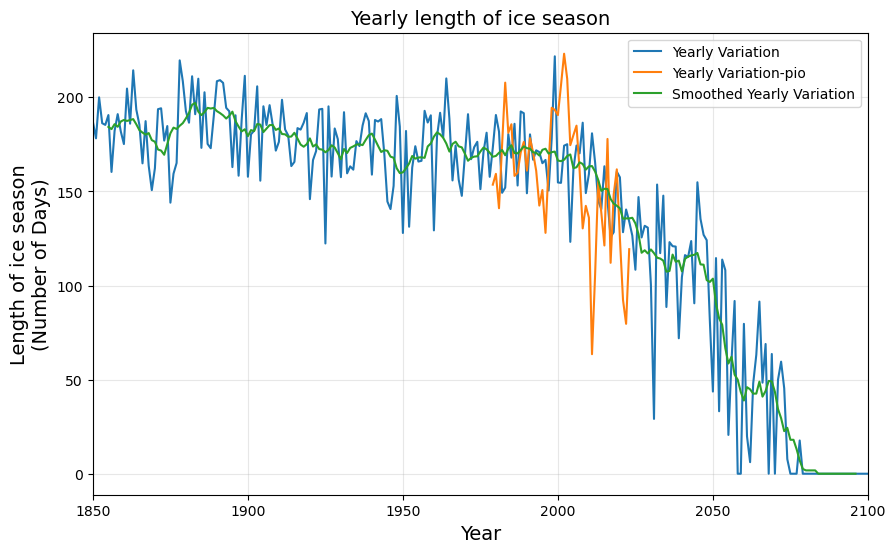

In [95]:
fig, ax=plt.subplots(figsize=(10,6))

# Calculate the mean across all years
#overall_mean = yearly_mean.mean('year')
# Create an array with the same size as the number of years with the overall mean value
#mean_line = np.full_like(yearly_mean, overall_mean)
# Plot the yearly variations and the mean line
ax.plot(ice_season_days_df['Year'], ice_season_days_df['Days'], label='Yearly Variation')
ax.plot(ice_season_days_df1['Year'],ice_season_days_df1['Days'], label='Yearly Variation-pio')
ax.plot(ice_season_days_df['Year'], ice_season_days_df['Days'].rolling(window=10, center=True).mean(), label='Smoothed Yearly Variation')

ax.set_title('Yearly length of ice season',  fontsize=14)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Length of ice season\n(Number of Days)', fontsize=14)
plt.grid(alpha=0.3)
plt.xlim(1850,2100)
plt.legend()
plt.savefig('/storage2/tkyeimiah/Plots/Iceseason_Length.jpg',dpi=500, bbox_inches='tight')
plt.show()

In [96]:
_1850 = all_hist.sel(time=str(1850))
_1900 = all_hist.sel(time=str(1900))
_1950 = all_hist.sel(time=str(1950))
_2000 = all_hist.sel(time=str(2000))
_2050 = all_hist.sel(time=str(2050))
_2100 = all_hist.sel(time=str(2100))

In [97]:
monthly_mean_1850 = _1850.groupby('time.month').mean('time').mean(('nj', 'ni')).fillna(0)
monthly_mean_1900 = _1900.groupby('time.month').mean('time').mean(('nj', 'ni')).fillna(0)
monthly_mean_1950 = _1950.groupby('time.month').mean('time').mean(('nj', 'ni')).fillna(0)
monthly_mean_2000 = _2000.groupby('time.month').mean('time').mean(('nj', 'ni')).fillna(0)
monthly_mean_2050 = _2050.groupby('time.month').mean('time').mean(('nj', 'ni')).fillna(0)
monthly_mean_2100 = _2100.groupby('time.month').mean('time').mean(('nj', 'ni')).fillna(0)

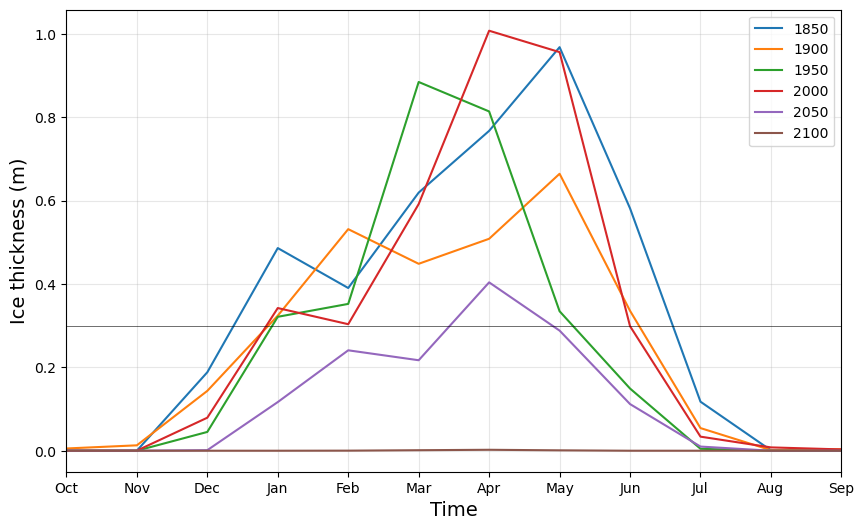

In [98]:
fig, ax=plt.subplots(figsize=(10,6))
month_dt = ['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug', 'Sep']
ax.plot(month_dt, np.append(monthly_mean_1850[9:],monthly_mean_1850[:9]) , label='1850')
ax.plot(month_dt, np.append(monthly_mean_1900[9:],monthly_mean_1900[:9]) , label='1900')
ax.plot(month_dt, np.append(monthly_mean_1950[9:],monthly_mean_1950[:9]) , label='1950')
ax.plot(month_dt, np.append(monthly_mean_2000[9:],monthly_mean_2000[:9]) , label='2000')
ax.plot(month_dt, np.append(monthly_mean_2050[9:],monthly_mean_2050[:9]) , label='2050')
ax.plot(month_dt, np.append(monthly_mean_2100[9:],monthly_mean_2100[:9]) , label='2100')
plt.axhline(y=0.3, color='black', linewidth=0.4)
#ax.set_title('Yearly length of ice season',  fontsize=14)
ax.set_xlabel('Time', fontsize=14)
ax.set_ylabel('Ice thickness (m)', fontsize=14)
plt.grid(alpha=0.3)
plt.xlim(0,11)
#plt.xlim(1850,2100)
plt.legend()
plt.savefig('/storage2/tkyeimiah/Plots/timeSeries.jpg',dpi=500, bbox_inches='tight')
plt.show()

In [99]:
march_hi

<xarray.DataArray 'hi' (time: 251)>
array([0.43154776, 0.503819  , 0.4754675 , 0.5487773 , 0.48190513,
       0.47649825, 0.58034873, 0.5197701 , 0.47998276, 0.4793127 ,
       0.4724419 , 0.44228253, 0.6025696 , 0.56554073, 0.5730944 ,
       0.46872133, 0.46246752, 0.4898717 , 0.55051637, 0.45272887,
       0.5170413 , 0.4749354 , 0.50226504, 0.45953292, 0.46447352,
       0.37881434, 0.32322568, 0.44447336, 0.5055611 , 0.5394384 ,
       0.5350241 , 0.60601795, 0.48578915, 0.50053644, 0.53677547,
       0.47248858, 0.49693972, 0.54712266, 0.43663976, 0.48325688,
       0.49831223, 0.54931396, 0.56016064, 0.5123874 , 0.43560258,
       0.4789872 , 0.4604059 , 0.39331448, 0.4026723 , 0.44942278,
       0.4796932 , 0.50085497, 0.472015  , 0.5923646 , 0.45622787,
       0.5223968 , 0.6013513 , 0.5879601 , 0.49229687, 0.5533385 ,
       0.44982043, 0.4837121 , 0.48941883, 0.42358753, 0.4759338 ,
       0.49596488, 0.57018   , 0.6390888 , 0.64098763, 0.38278535,
       0.36723402, 0.48536918, 0.5121963 , 0.5231616 , 0.48131117,
       0.4531293 , 0.474503  , 0.45016047, 0.42329547, 0.48303133,
       0.5250376 , 0.4458969 , 0.49330196, 0.47426066, 0.51956356,
       0.52505165, 0.58448756, 0.53468853, 0.49973184, 0.42998964,
       0.4741175 , 0.43575895, 0.4586762 , 0.46659368, 0.52097   ,
       0.45811516, 0.4341292 , 0.4854564 , 0.34762534, 0.40649998,
...
       0.42485106, 0.38802347, 0.40016183, 0.4436117 , 0.38489363,
       0.4604639 , 0.36845523, 0.45570144, 0.37037173, 0.36980367,
       0.33500853, 0.3671314 , 0.3268072 , 0.39152184, 0.35669214,
       0.36722347, 0.32524508, 0.37837383, 0.3288643 , 0.36530066,
       0.2653514 , 0.37652227, 0.28383714, 0.28913847, 0.2851401 ,
       0.29624102, 0.26850337, 0.3320353 , 0.3674755 , 0.35803878,
       0.2854788 , 0.24707149, 0.30375195, 0.3064744 , 0.28197882,
       0.34997794, 0.2985699 , 0.24028672, 0.27950704, 0.36148468,
       0.3987815 , 0.32685715, 0.33306766, 0.28576753, 0.25657272,
       0.21370499, 0.25352857, 0.21770744, 0.2907656 , 0.25307208,
       0.24731575, 0.22804175, 0.20861138, 0.15805475, 0.14838305,
       0.1832867 , 0.2221538 , 0.26330072, 0.22968327, 0.17687975,
       0.20012672, 0.18508735, 0.25020555, 0.1601036 , 0.17554547,
       0.16952078, 0.17073737, 0.1654985 , 0.11836518, 0.11176029,
       0.10382743, 0.08155624, 0.12756811, 0.15952194, 0.13681401,
       0.11168768, 0.11711054, 0.08341922, 0.08327191, 0.0402457 ,
       0.06284614, 0.03993896, 0.03483613, 0.03209446, 0.06424241,
       0.03793113, 0.04230483, 0.05120233, 0.0335571 , 0.03376329,
       0.01363612, 0.01650329, 0.0098087 , 0.00353175, 0.01024623,
       0.01170824], dtype=float32)
Coordinates:
  * time     (time) object 1850-03-01 00:00:00 ... 2100-03-01 00:00:00

NameError: name 'model_obs' is not defined

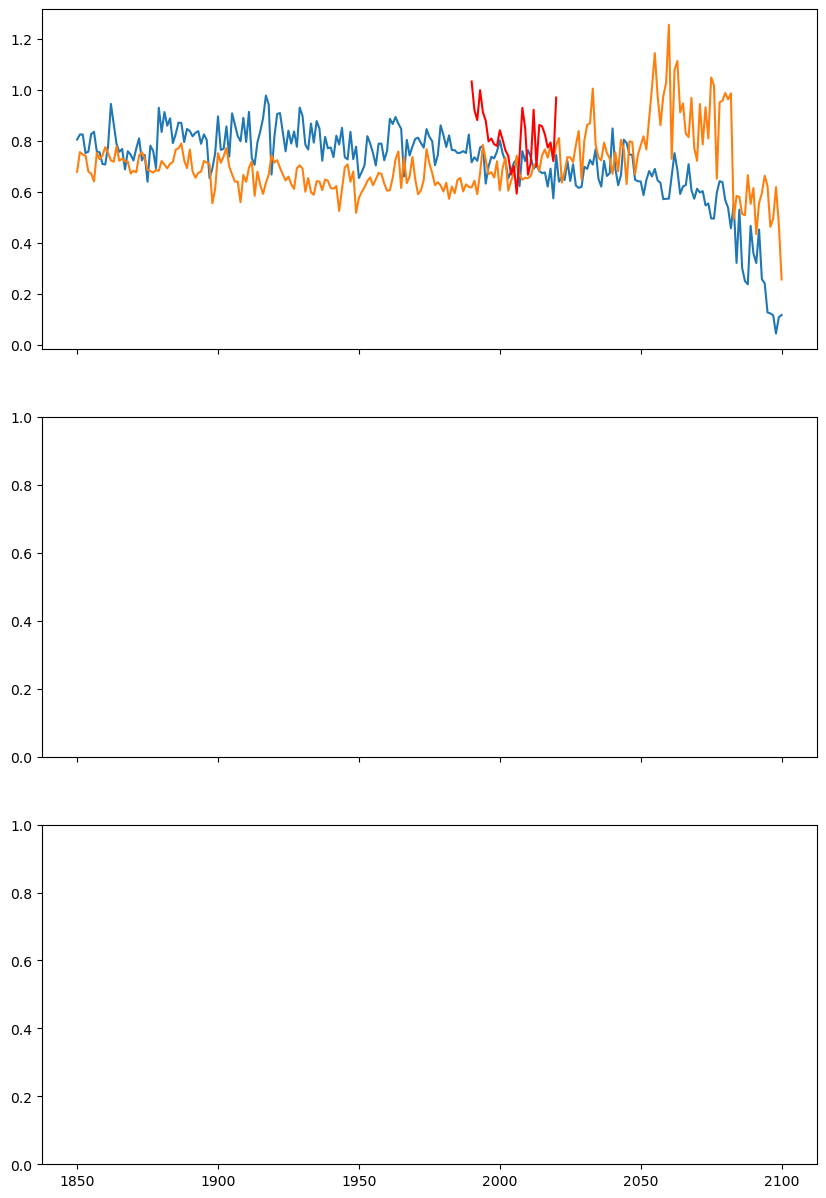

In [100]:
# SIE  : CESM-HR
march_aice_hist = aice_hist_region.sel(time=slice('1850','2005'))[2::12].sum(('nj', 'ni'))
march_aice_proj = aice_proj_region.sel(time=slice('2006','2100'))[2::12].sum(('nj', 'ni'))
march_aice=xr.concat([march_aice_hist,march_aice_proj], dim='time')

# SIE : CIS
obs_SIE=obs_CT_region.sel(time=slice('1990','2020'))
obs_SIE_march=obs_SIE[2::12].sum(['rlat','rlon'])

# SIT : CESM-HR
march_hi_hist = hi_hist_region1.sel(time=slice('1850','2005'))[3::12].mean(('nj', 'ni'))
march_hi_proj = hi_proj_region1.sel(time=slice('2006','2100'))[3::12].mean(('nj', 'ni'))
march_hi=xr.concat([march_hi_hist,march_hi_proj], dim='time')

# SIT : PIOMAS
march_piomas_hi = piomas_hi[3::12].mean(('y', 'x'))


fig, ax = plt.subplots(3, 1, figsize=(10, 15), sharex=True)
years =np.arange(1850,2101,1)

# First plot              
ax[0].plot(years, march_aice, label='CESM-HR')
ax[0].plot(years, march_aice_LR, label='CESM2-LE')
ax[0].plot(np.arange(1990,2021), obs_SIE_march, color='red', label='CIS')
ax[0].plot(time, model_obs.predict(time_ordinal), label='Observed Trend', linestyle='--', color='blue')
ax[0].plot(time, model_mod.predict(time_ordinal), label='Modeled Trend', linestyle='--', color='orange')
ax[0].set_ylabel('Sea Ice Extent\n[million km$^2$]', fontsize=14)
ax[0].grid(alpha=0.15)     
ax[0].legend(loc='lower left')
ax[0].set_xlim(1850, 2101)

# Second plot         
ax[1].plot(years, march_hi.fillna((0.08338354+0.1498341)/2), label='CESM-HR')
ax[1].plot(np.arange(1979,2024), march_piomas_hi, color='red', label='PIOMAS')
ax[1].set_ylabel('Sea Ice Thickness\n[m]', fontsize=14)
ax[1].grid(alpha=0.15)
ax[1].legend(loc='lower left') 

# Third plot         
ax[2].plot(years, ice_season_days_df['Days'], label='CESM-HR')
ax[2].plot(np.arange(1979,2024), ice_season_days_df1['Days'], color='red', label='PIOMAS')
ax[2].set_ylabel('Length of ice season\n[No. of Days)]', fontsize=14)
ax[2].grid(alpha=0.15)
ax[2].legend(loc='lower left') 
ax[2].set_xlabel('Year', fontsize=14)

rect=ax[0].add_patch(Rectangle((2050, 0.43), 35, 0.86, edgecolor='black',facecolor='none',lw=3,))
rect.set_zorder(10)

# Increase the size of the tick labels
for axis in ax:
    axis.tick_params(axis='both', which='major', labelsize=12)

ax[0].text(0.01, 0.95, 'a)',transform=ax[0].transAxes,  fontsize=14)
ax[1].text(0.01, 0.95, 'b)',transform=ax[1].transAxes,  fontsize=14)
ax[2].text(0.01, 0.95, 'c)',transform=ax[2].transAxes,  fontsize=14)
plt.subplots_adjust(hspace=0.05)
plt.savefig('/storage2/tkyeimiah/Plots/new-Fig2.jpg', dpi=500, bbox_inches='tight')
plt.show()

In [ ]:
plt.plot(np.arange(1990,2021),obs_SIE_march, marker='o')
plt.plot(np.arange(1990,2021),march_aice.sel(time=slice('1990','2020')), marker='o')
plt.grid()

### Rate of decline

In [ ]:
march_piomas_hi

In [ ]:
observed=obs_SIE_march
modeled=march_aice.sel(time=slice('1990','2020'))
observed=march_piomas_hi.sel(time=slice('1990','2020'))
modeled=march_hi.sel(time=slice('1990','2020'))

In [ ]:
# Extract time as pandas datetime
time = observed['time'].to_pandas()
time_ordinal = time.map(pd.Timestamp.toordinal).values.reshape(-1, 1)

In [ ]:

# Convert to numpy arrays for regression
observed_values = observed.values
modeled_values = modeled.values

# Linear regression for observed data
model_obs = LinearRegression().fit(time_ordinal, observed_values)
rate_obs = model_obs.coef_[0]

# Linear regression for modeled data
model_mod = LinearRegression().fit(time_ordinal, modeled_values)
rate_mod = model_mod.coef_[0]

print(f"Rate of decline (Observed): {rate_obs} million km² per year")
print(f"Rate of decline (Modeled): {rate_mod} million km² per year")

## 

In [ ]:
# Plotting the data
plt.figure(figsize=(12, 6))
plt.plot(time, observed, label='Observed', color='blue')
plt.plot(time, modeled, label='Modeled', color='orange')

# Adding the regression lines
plt.plot(time, model_obs.predict(time_ordinal), label='Observed Trend', linestyle='--', color='blue')
plt.plot(time, model_mod.predict(time_ordinal), label='Modeled Trend', linestyle='--', color='orange')

plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title('Observed vs. Modeled Data')
plt.show()


### Statistics Analysis

In [ ]:
# Calculate the difference between the two periods for the model data
diff_model = model_2001_20_monthly - model_1991_00_monthly

# Calculate the difference between the two periods for the CIS data
diff_cis = cis_2001_20_monthly - cis_1991_00_monthly

# Calculate the Mean Squared Error (MSE) for the model and CIS differences
mse_model = np.mean(diff_model ** 2)
mse_cis = np.mean(diff_cis ** 2)

# Calculate the loss between the two periods for the model
loss_model = mse_model

# Calculate the loss between the two periods for the CIS data
loss_cis = mse_cis

print(f"Model Loss between the two periods: {loss_model}")
print(f"CIS Loss between the two periods: {loss_cis}")

In [ ]:
# Calculate the difference between model and observation for each period
diff_1991_00 = model_1991_00_monthly - cis_1991_00_monthly
diff_2001_20 = model_2001_20_monthly - cis_2001_20_monthly

# Calculate the Mean Squared Error (MSE) for each period
mse_1991_00 = np.mean(diff_1991_00 ** 2)
mse_2001_20 = np.mean(diff_2001_20 ** 2)

# Calculate the loss (difference in MSE between the two periods)
loss = mse_2001_20 - mse_1991_00

print(f"Loss between the two periods: {loss}")

In [ ]:
# Calculate the difference between model and observation for each period
diff_1991_00 = model_1991_00_monthly - cis_1991_00_monthly
diff_2001_20 = model_2001_20_monthly - cis_2001_20_monthly

# Calculate the Mean Squared Error (MSE) for each period
mse_1991_00 = np.mean(diff_1991_00 ** 2)
mse_2001_20 = np.mean(diff_2001_20 ** 2)

# Calculate the loss for each period
loss_1991_00 = mse_1991_00
loss_2001_20 = mse_2001_20

print(f"Loss for the 1991-2000 period: {loss_1991_00}")
print(f"Loss for the 2001-2020 period: {loss_2001_20}")

In [ ]:
# Calculate the difference between model and observation for each period
diff_1991_00 = model_1991_00_monthly - cis_1991_00_monthly
diff_2001_20 = model_2001_20_monthly - cis_2001_20_monthly

# Calculate the Mean Squared Error (MSE) for each period
mse_1991_00 = np.mean(diff_1991_00 ** 2)
mse_2001_20 = np.mean(diff_2001_20 ** 2)

# Calculate the Mean Bias Error (MBE) for each period
mbe_1991_00 = np.mean(diff_1991_00)
mbe_2001_20 = np.mean(diff_2001_20)

print(f"Loss (MSE) for the 1991-2000 period: {mse_1991_00}")
print(f"Loss (MSE) for the 2001-2020 period: {mse_2001_20}")
print(f"Bias (MBE) for the 1991-2000 period: {mbe_1991_00}")
print(f"Bias (MBE) for the 2001-2020 period: {mbe_2001_20}")

In [ ]:
# Calculate the difference between model and observation for each period
diff_1991_00hi = model_hi_1991_00_monthly - piomas_hi_1991_00_monthly
diff_2001_20hi = model_hi_2001_20_monthly - piomas_hi_2001_20_monthly

# Calculate the Mean Squared Error (MSE) for each period
mse_1991_00hi = np.mean(diff_1991_00hi ** 2)
mse_2001_20hi = np.mean(diff_2001_20hi ** 2)

# Calculate the Mean Bias Error (MBE) for each period
mbe_1991_00hi = np.mean(diff_1991_00hi)
mbe_2001_20hi = np.mean(diff_2001_20hi)

print(f"Loss (MSE) for the 1991-2000 period: {mse_1991_00hi}")
print(f"Loss (MSE) for the 2001-2020 period: {mse_2001_20hi}")
print(f"Bias (MBE) for the 1991-2000 period: {mbe_1991_00hi}")
print(f"Bias (MBE) for the 2001-2020 period: {mbe_2001_20hi}")

In [ ]:
diff_1991_00hi

In [ ]:
diff_2001_20hi

In [ ]:

# Calculate the difference between model and observation for each period
diff_1991_00hi = model_hi_1991_00_monthly - piomas_hi_1991_00_monthly
diff_2001_20hi = model_hi_2001_20_monthly - piomas_hi_2001_20_monthly

# Calculate the Mean Squared Error (MSE) for each period
mse_1991_00hi = np.mean(diff_1991_00hi ** 2)
mse_2001_20hi = np.mean(diff_2001_20hi ** 2)

# Calculate the loss for each period
loss_1991_00hi = mse_1991_00hi
loss_2001_20hi = mse_2001_20hi

print(f"Loss for the 1991-2000 period: {loss_1991_00hi}")
print(f"Loss for the 2001-2020 period: {loss_2001_20hi}")

In [ ]:
# Calculate the difference between model and observation for each period
interannual = march_aice.sel(time=slice('1990','2020')).values-obs_SIE_march.values

# Calculate the Mean Squared Error (MSE) for each period
inter = np.mean(interannual** 2 )

# Calculate the Mean Bias Error (MBE) for each period
mbe = np.mean(inter)

print(f"Loss (MSE) for the 1991-2000 period: {inter}")
print(f"Bias (MBE) for the 1991-2000 period: {mbe}")

In [ ]:
# Calculate the difference between model and observation for each period
interannual = model_sic_1991_00_.mean(('nj', 'ni')).values-cis_sic_1991_00_.mean(('rlat','rlon')).values

# Calculate the Mean Squared Error (MSE) for each period
inter = np.mean(interannual**2 )

# Calculate the Mean Bias Error (MBE) for each period
mbe = np.mean(inter)

print(f"Loss (MSE) for the 1991-2000 period: {inter}")
print(f"Bias (MBE) for the 1991-2000 period: {mbe}")

In [ ]:
ice_season_days_df.tail(-157)

In [ ]:
ice_season_days_df1

In [ ]:
np.nanmax(model_2081_100.sel(time='2100').mean(('nj','ni')).values)

In [ ]:
2.5722851911001126e-06*10**(6)

In [ ]:
12.156142907620584e-06


In [ ]:
np.mean(model_2081_100.sel(time='2100').mean(('nj','ni')).values)

In [ ]:
march_hi

### Coastal Areas

#### town_names = ['Nain', 'Hopedale', 'Rigolet', 'Postville']  
#### point_lon = [-61.69, -60.21, -58.42, -59.77] 
#### point_lat = [56.54, 55.45, 54.17, 54.91]  

In [ ]:
360-59.77

In [ ]:
nain_lon_min, nain_lon_max =298, 299 #298.31 W  # -61.69
nain_lat_min, nain_lat_max =56.52,56.55  #56.54 N

hope_lon_min, hope_lon_max =299, 300#299.79 W  # -60.21
hope_lat_min, hope_lat_max =55.4,55.5  #55.45 N

post_lon_min, post_lon_max =300, 302 #300.23 W  # -59.77
post_lat_min, post_lat_max =54.9,54.93  #54.91 N

rigo_lon_min, rigo_lon_max =301.5, 303 #301.58 W  # -58.42
rigo_lat_min, rigo_lat_max =54.16,54.3  #54.17 N


def mask(lon_min,lon_max,lat_min,lat_max):
    mask1 = ((hi_hist_region1.TLAT >=  lat_min) & (hi_hist_region1.TLAT <=  lat_max) &
            (hi_hist_region1.TLON >= lon_min) & (hi_hist_region1.TLON <= lon_max))
    
    mask2 = ((hi_proj_region1.TLAT >=  lat_min) & (hi_proj_region1.TLAT <=  lat_max) &
            (hi_proj_region1.TLON >= lon_min) & (hi_proj_region1.TLON <= lon_max))
    
    model_region1=hi_hist_region1.sel(time=slice('1850','2005')).where(mask1, drop=True)
    model_region2=hi_proj_region1.sel(time=slice('2006','2100')).where(mask2, drop=True)
    
    model_region=xr.concat([model_region1,model_region2], dim='time')
    return model_region

nain_hi = mask (nain_lon_min,nain_lon_max,nain_lat_min,nain_lat_max)
hope_hi = mask (hope_lon_min,hope_lon_max,hope_lat_min,hope_lat_max)
post_hi = mask (post_lon_min,post_lon_max,post_lat_min,post_lat_max)
rigo_hi = mask (rigo_lon_min,rigo_lon_max,rigo_lat_min,rigo_lat_max)

In [ ]:
#nain
nain_hi_1991_00=nain_hi.sel(time=slice('1991','2000')).groupby('time.month').mean('time').mean(('nj', 'ni')).fillna(0)
nain_hi_2001_20=nain_hi.sel(time=slice('2001','2020')).groupby('time.month').mean('time').mean(('nj', 'ni')).fillna(0)
nain_hi_2041_60=nain_hi.sel(time=slice('2041','2060')).groupby('time.month').mean('time').mean(('nj', 'ni')).fillna(0)
nain_hi_2081_100=nain_hi.sel(time=slice('2081','2100')).groupby('time.month').mean('time').mean(('nj', 'ni')).fillna(0)

#hope
hope_hi_1991_00=hope_hi.sel(time=slice('1991','2000')).groupby('time.month').mean('time').mean(('nj', 'ni')).fillna(0)
hope_hi_2001_20=hope_hi.sel(time=slice('2001','2020')).groupby('time.month').mean('time').mean(('nj', 'ni')).fillna(0)
hope_hi_2041_60=hope_hi.sel(time=slice('2041','2060')).groupby('time.month').mean('time').mean(('nj', 'ni')).fillna(0)
hope_hi_2081_100=hope_hi.sel(time=slice('2081','2100')).groupby('time.month').mean('time').mean(('nj', 'ni')).fillna(0)

#post
post_hi_1991_00=post_hi.sel(time=slice('1991','2000')).groupby('time.month').mean('time').mean(('nj', 'ni')).fillna(0)
post_hi_2001_20=post_hi.sel(time=slice('2001','2020')).groupby('time.month').mean('time').mean(('nj', 'ni')).fillna(0)
post_hi_2041_60=post_hi.sel(time=slice('2041','2060')).groupby('time.month').mean('time').mean(('nj', 'ni')).fillna(0)
post_hi_2081_100=post_hi.sel(time=slice('2081','2100')).groupby('time.month').mean('time').mean(('nj', 'ni')).fillna(0)

#rigo
rigo_hi_1991_00=rigo_hi.sel(time=slice('1991','2000')).groupby('time.month').mean('time').mean(('nj', 'ni')).fillna(0)
rigo_hi_2001_20=rigo_hi.sel(time=slice('2001','2020')).groupby('time.month').mean('time').mean(('nj', 'ni')).fillna(0)
rigo_hi_2041_60=rigo_hi.sel(time=slice('2041','2060')).groupby('time.month').mean('time').mean(('nj', 'ni')).fillna(0)
rigo_hi_2081_100=rigo_hi.sel(time=slice('2081','2100')).groupby('time.month').mean('time').mean(('nj', 'ni')).fillna(0)

In [ ]:
fig, ax=plt.subplots(2,2, figsize=(15,10), sharey=True, sharex=True)
month_dt = ['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug', 'Sep']
ax[0,0].plot(month_dt, np.append(nain_hi_1991_00[9:],nain_hi_1991_00[:9]) , label='Nain')
ax[0,0].plot(month_dt, np.append(hope_hi_1991_00[9:],hope_hi_1991_00[:9]) , label='Hopedale')
ax[0,0].plot(month_dt, np.append(post_hi_1991_00[9:],post_hi_1991_00[:9]) , label='Postville')
ax[0,0].plot(month_dt, np.append(rigo_hi_1991_00[9:],rigo_hi_1991_00[:9]) , label='Rigolet')
ax[0,0].set_ylabel('Ice thickness (m)', fontsize=14)
ax[0,0].set_title('1991-2000')
ax[0,0].grid(alpha=0.15)
ax[0,0].axhline(y=0.3, color='black', linewidth=1)

ax[0,1].plot(month_dt, np.append(nain_hi_2001_20[9:],nain_hi_2001_20[:9]) , label='Nain')
ax[0,1].plot(month_dt, np.append(hope_hi_2001_20[9:],hope_hi_2001_20[:9]) , label='Hopedale')
ax[0,1].plot(month_dt, np.append(post_hi_2001_20[9:],post_hi_2001_20[:9]) , label='Postville')
ax[0,1].plot(month_dt, np.append(rigo_hi_2001_20[9:],rigo_hi_2001_20[:9]) , label='Rigolet')
ax[0,1].plot(month_dt, np.append(sat_mean_monthly['Hice_Mean'][9:]*0.01, sat_mean_monthly['Hice_Mean'][:9]*0.01), label='Satosoak')
ax[0,1].plot(month_dt, np.append(tak_mean_monthly['Hice_Mean'][9:]*0.01, tak_mean_monthly['Hice_Mean'][:9]*0.01), label='TakTok')
ax[0,1].legend()
ax[0,1].set_title('2001-2020')
ax[0,1].grid(alpha=0.15)
ax[0,1].axhline(y=0.3, color='black', linewidth=1)

ax[1,0].plot(month_dt, np.append(nain_hi_2041_60[9:],nain_hi_2041_60[:9]) )
ax[1,0].plot(month_dt, np.append(hope_hi_2041_60[9:],hope_hi_2041_60[:9]) )
ax[1,0].plot(month_dt, np.append(post_hi_2041_60[9:],post_hi_2041_60[:9]) )
ax[1,0].plot(month_dt, np.append(rigo_hi_2041_60[9:],rigo_hi_2041_60[:9]) )
ax[1,0].set_ylabel('Ice thickness (m)', fontsize=14)
ax[1,0].set_xlabel('Time', fontsize=14)
ax[1,0].set_title('2041-2060')
ax[1,0].grid(alpha=0.15)
ax[1,0].axhline(y=0.3, color='black', linewidth=1)

ax[1,1].plot(month_dt, np.append(nain_hi_2081_100[9:],nain_hi_2081_100[:9]) )
ax[1,1].plot(month_dt, np.append(hope_hi_2081_100[9:],hope_hi_2081_100[:9]) )
ax[1,1].plot(month_dt, np.append(post_hi_2081_100[9:],post_hi_2081_100[:9]) )
ax[1,1].plot(month_dt, np.append(rigo_hi_2081_100[9:],rigo_hi_2081_100[:9]) )
ax[1,1].set_xlabel('Time', fontsize=14)
ax[1,1].set_title('2081-2100')
ax[1,1].grid(alpha=0.15)
ax[1,1].axhline(y=0.3, color='black', linewidth=1)

plt.subplots_adjust(hspace=0.09, wspace=0.05)
plt.xlim(0,11)

plt.savefig('/storage2/tkyeimiah/Plots/cities_timeseries.jpg',dpi=500, bbox_inches='tight')
plt.show()